# i. Business Understanding

## i.i Blocker Fraud Company

* The Blocker Fraud Company is a company specialized in detecting fraud in financial transactions made through mobile devices. The company has a service called “Blocker Fraud” with no guarantee of blocking fraudulent transactions.

* And the business model of the company is of the Service type with the monetization made by the performance of the service provided, that is, the user pays a fixed fee on the success in detecting fraud in the customer's transactions.

### i.i.i Expansion Problem

Blocker Fraud Company is expanding in Brazil and to acquire customers more quickly, it has adopted a very aggressive strategy. The strategy works as follows:
1. The company will receive 25% of the value of each transaction that is truly detected as fraud.
1. The company will receive 5% of the value of each transaction detected as fraud, but the transaction is truly legitimate.
1. The company will return 100% of the value to the customer, for each transaction detected as legitimate, however the transaction is truly a fraud.

## i.ii The Challenge

You need to deliver to the CEO of Blocker Fraud Company a production model in which your access will be done via API, that is, customers will send their transactions via API so that your model classifies them as fraudulent or legitimate.

### i.ii.i Business Questions

1. What is the model's Precision and Accuracy?
1. How Reliable is the model in classifying transactions as legitimate or fraudulent?
1. What is the Expected Billing by the Company if we classify 100% of transactions with the model?
1. What is the Loss Expected by the Company in case of model failure?
1. What is the Profit Expected by the Blocker Fraud Company when using the model?

# 0.0 Imports and Helper Functions

In [3]:
!pip3 install --upgrade seaborn inflection category_encoders

## 0.1 Imports

In [4]:
import joblib
import warnings
import inflection

import numpy             as np
import pandas            as pd
import seaborn           as sns

import matplotlib.pyplot as plt

from scipy   import stats
from category_encoders import OneHotEncoder

from IPython.display      import Image
from IPython.core.display import HTML

from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm          import SVC
from sklearn.dummy        import DummyClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics         import balanced_accuracy_score, precision_score, classification_report, roc_curve, auc, RocCurveDisplay
from sklearn.metrics         import recall_score, f1_score, make_scorer, cohen_kappa_score
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold

## 0.2 Helper Functions

In [5]:
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

In [6]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    sns.set(font_scale=1.6)

    plt.style.use('seaborn-v0_8-darkgrid')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16

    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [7]:
def ml_scores(model_name, y_true, y_pred):

    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    roc = roc_curve(y_true, y_pred)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    aucv = auc(fpr, tpr)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3),
                         'Precision': np.round(precision, 3),
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'Kappa': np.round(kappa, 3),
                         'ROC': np.round(roc, 3),
                         'AUC': np.round(aucv, 3)},
                        index=[model_name])

In [8]:
def calcCramerV(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [9]:
def ml_cv_results(model_name, model, x, y, verbose=1):

    '''initial'''
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1s = []
    kappas = []

    mm = MinMaxScaler()

    x_ = x.to_numpy()
    y_ = y.to_numpy()

    count = 0

    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True)

    for index_train, index_test in skf.split(x_, y_):
        ## Showing the Fold
        if verbose > 0:
            count += 1
            print('Fold K=%i' % (count))

        ## selecting train and test
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]

        ## applying the scale
        x_train = mm.fit_transform(x_train)
        x_test = mm.transform(x_test)

        ## training the model
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        ## saving the metrics
        balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        kappas.append(cohen_kappa_score(y_test, y_pred))


    '''results'''
    accuracy_mean, accuracy_std = np.round(np.mean(balanced_accuracies), 3), np.round(np.std(balanced_accuracies), 3)
    precision_mean, precision_std = np.round(np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)
    kappa_mean, kappa_std = np.round(np.mean(kappas), 3), np.round(np.std(kappas), 3)

    ## saving the results in a dataframe
    return pd.DataFrame({"Balanced Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std),
                        "Kappa": "{} +/- {}".format(kappa_mean, kappa_std)},
                       index=[model_name])

# 1.0 Data Description

## 1.1 Loading Data

In [10]:
df1 = pd.read_csv('fraud_data.csv')

In [11]:
df1.shape

(636262, 11)

In [12]:
df1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,0,0
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,0,0
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,0,0
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,0,0
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,0,0


In [13]:
df1.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
636257,351,CASH_OUT,28761.10,C742050657,0.0,0.00,C568407561,328534.52,357295.62,0,0
636258,184,CASH_OUT,167820.71,C561181412,62265.0,0.00,C1852953580,106429.48,274250.18,0,0
636259,35,PAYMENT,8898.12,C1773417333,30808.0,21909.88,M445701551,0.00,0.00,0,0
636260,277,CASH_OUT,176147.90,C1423233247,83669.0,0.00,C1328739120,0.00,176147.90,0,0
636261,304,CASH_OUT,95142.89,C874575079,0.0,0.00,C666451134,431380.07,526522.96,0,0


## 1.2 Columns

### 1.2.1 Column Descriptions

**step:** maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type:** CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount:** amount of the transaction in local currency.

**nameOrig:** customer who started the transaction

**oldbalanceOrg:** initial balance before the transaction

**newbalanceOrig:** new balance after the transaction

**nameDest:** customer who is the recipient of the transaction

**oldbalanceDest:** initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest:** new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud:** This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud:** The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

### 1.2.2 Column Rename

In [14]:
cols_old = df1.columns.tolist()

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [15]:
df1.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

## 1.3 Data Dimension

In [16]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 636262
Number of Cols: 11


## 1.4 Data Types and Structure

In [17]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636262 entries, 0 to 636261
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   step              636262 non-null  int64  
 1   type              636262 non-null  object 
 2   amount            636262 non-null  float64
 3   name_orig         636262 non-null  object 
 4   oldbalance_org    636262 non-null  float64
 5   newbalance_orig   636262 non-null  float64
 6   name_dest         636262 non-null  object 
 7   oldbalance_dest   636262 non-null  float64
 8   newbalance_dest   636262 non-null  float64
 9   is_fraud          636262 non-null  int64  
 10  is_flagged_fraud  636262 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 53.4+ MB


## 1.5 Check NA

In [18]:
df1.isna().mean()

step                0.0
type                0.0
amount              0.0
name_orig           0.0
oldbalance_org      0.0
newbalance_orig     0.0
name_dest           0.0
oldbalance_dest     0.0
newbalance_dest     0.0
is_fraud            0.0
is_flagged_fraud    0.0
dtype: float64

## 1.6 Fill Out NA

There's no NaN values to fill.

## 1.7 Change Data Type

 I will change the values 0 and 1 to 'yes' and 'no'. It'll help on the data description and analysis sections.

In [19]:
df1['is_fraud'] = df1['is_fraud'].map({1: 'yes', 0: 'no'})
df1['is_flagged_fraud'] = df1['is_flagged_fraud'].map({1: 'yes', 0: 'no'})

## 1.8 Description Statistics

In [20]:
num_attributes = df1.select_dtypes(exclude='object')
cat_attributes = df1.select_dtypes(include='object')

### 1.8.1 Numerical Attributes

In [21]:
describe = num_attributes.describe().T

describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()

describe

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
step,636262.0,2.429319e+02,1.423309e+02,1.0,155.000,238.000,3.340000e+02,7.420000e+02,7.410000e+02,0.585888,0.375052,0.324437
amount,636262.0,1.800585e+05,6.069714e+05,0.0,13407.425,74815.770,2.084988e+05,5.722962e+07,5.722962e+07,3.370967,29.577107,1546.661043
oldbalance_org,636262.0,8.317937e+05,2.885636e+06,0.0,0.000,14239.000,1.072998e+05,4.368662e+07,4.368662e+07,3.469173,5.243428,32.766036
newbalance_orig,636262.0,8.528354e+05,2.921296e+06,0.0,0.000,0.000,1.435652e+05,4.367380e+07,4.367380e+07,3.425393,5.173614,31.932547
oldbalance_dest,636262.0,1.096212e+06,3.375389e+06,0.0,0.000,131539.745,9.384820e+05,3.551855e+08,3.551855e+08,3.079138,20.622388,1074.335293
newbalance_dest,636262.0,1.221809e+06,3.656213e+06,0.0,0.000,214712.725,1.109230e+06,3.555534e+08,3.555534e+08,2.992460,19.623903,928.694204


* All the data has a coeficient of variation greater than 25%, therefore they aren't homogeneous.

* The step variable starts from 1 hour to 742 hour (30 days).

* Some variables are higher shap and right skewed.

* 50% of the newbalance_orig is 0. Maybe there are some transfers that don't go to the destination.

* The skew is higher positive, therefore the values may be in less values.

### 1.8.2 Categorical Attributes

In [22]:
cat_attributes.describe()

,type,name_orig,name_dest,is_fraud,is_flagged_fraud
count,636262,636262,636262,636262,636262
unique,5,636171,457224,2,2
top,CASH_OUT,C334643493,C2083562754,no,no
freq,224216,2,14,635441,636260


* The majority type is cash_out with 2237500.

* There's a lot of variability in name_orig, so it could be hard to use one hot encoding.

* There's less name_orig than name_dest. There's more users sending than receiving, however use one hot encoding will not help.

* There's more fraud than the flagged fraud, it shows that the current method can't recognize fraud efficiently.

# 2.0 Feature Engineering

In [23]:
df2 = df1.copy()

## 2.1 Mind Map

## 2.2 Hypothesis Creation

### 2.2.1 User

* 90% of the twentyone-year-old users did a fraud transiction.

* The majority fraud transiction occours for the same initial letter user.

* The fraud amount is greater than 10.000.

* The 60% of the age is greater than 30 year old.

### 2.2.2 Type

* 60% of fraud transaction occours using cash-out-type method.

* The majority transfers occours using tranfers-type method.

* Values greater than 100.000 occours using transfers-type method.

* Payment type occurs with values lower than 100.000

### 2.2.3 Origin and Destiny Transactions

* 60% of the difference between origin destiny transactions is equal 0 for frauds.

* Origin values are greater than destiny values for fraud transaction.

### 2.2.4 Time

* Fraud transactions occours at least in 3 days.

* 40% of the cash-out transactions occours less than 1 day.

* 60% of the transaction less than 100.000 occours at least 10 days.

* The transactions greater than 10.000 occours at most in 2 weeks.

## 2.3 Hipothesys List

1. The majority fraud transiction occours for the same initial letter user.

1. All the fraud amount is greater than 10.000.

1. 60% of fraud transaction occours using cash-out-type method.

1. The majority transfers occours using tranfers-type method.

1. Fraud transactions occours at least in 3 days.

## 2.4 Feature Engineering

In [24]:
# step
df2['step_days'] = df2['step'].apply(lambda i: i/24)
df2['step_weeks'] = df2['step'].apply(lambda i: i/(24*7))

# difference between initial balance before the transaction and new balance after the transaction
df2['diff_new_old_balance'] = df2['newbalance_orig'] - df2['oldbalance_org']

# difference between initial balance recipient before the transaction and new balance recipient after the transaction.
df2['diff_new_old_destiny'] = df2['newbalance_dest'] - df2['oldbalance_dest']

# name orig and name dest
# df2['name_orig'] = df2['name_orig'].apply(lambda i: i[0])
# df2['name_dest'] = df2['name_dest'].apply(lambda i: i[0])
df2['name_orig'] = df2['name_orig'].apply(lambda i: str(i)[0])
df2['name_dest'] = df2['name_dest'].apply(lambda i: str(i)[0])

# 3.0 Selecting Columns

In [25]:
df3 = df2.copy()

## 3.1 Selecting Columns

I'll use all the columns for data analysis

## 3.2 Selecting Lines

I'll use all the lines.

# 4.0 Exploratory Data Analisys

In [26]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

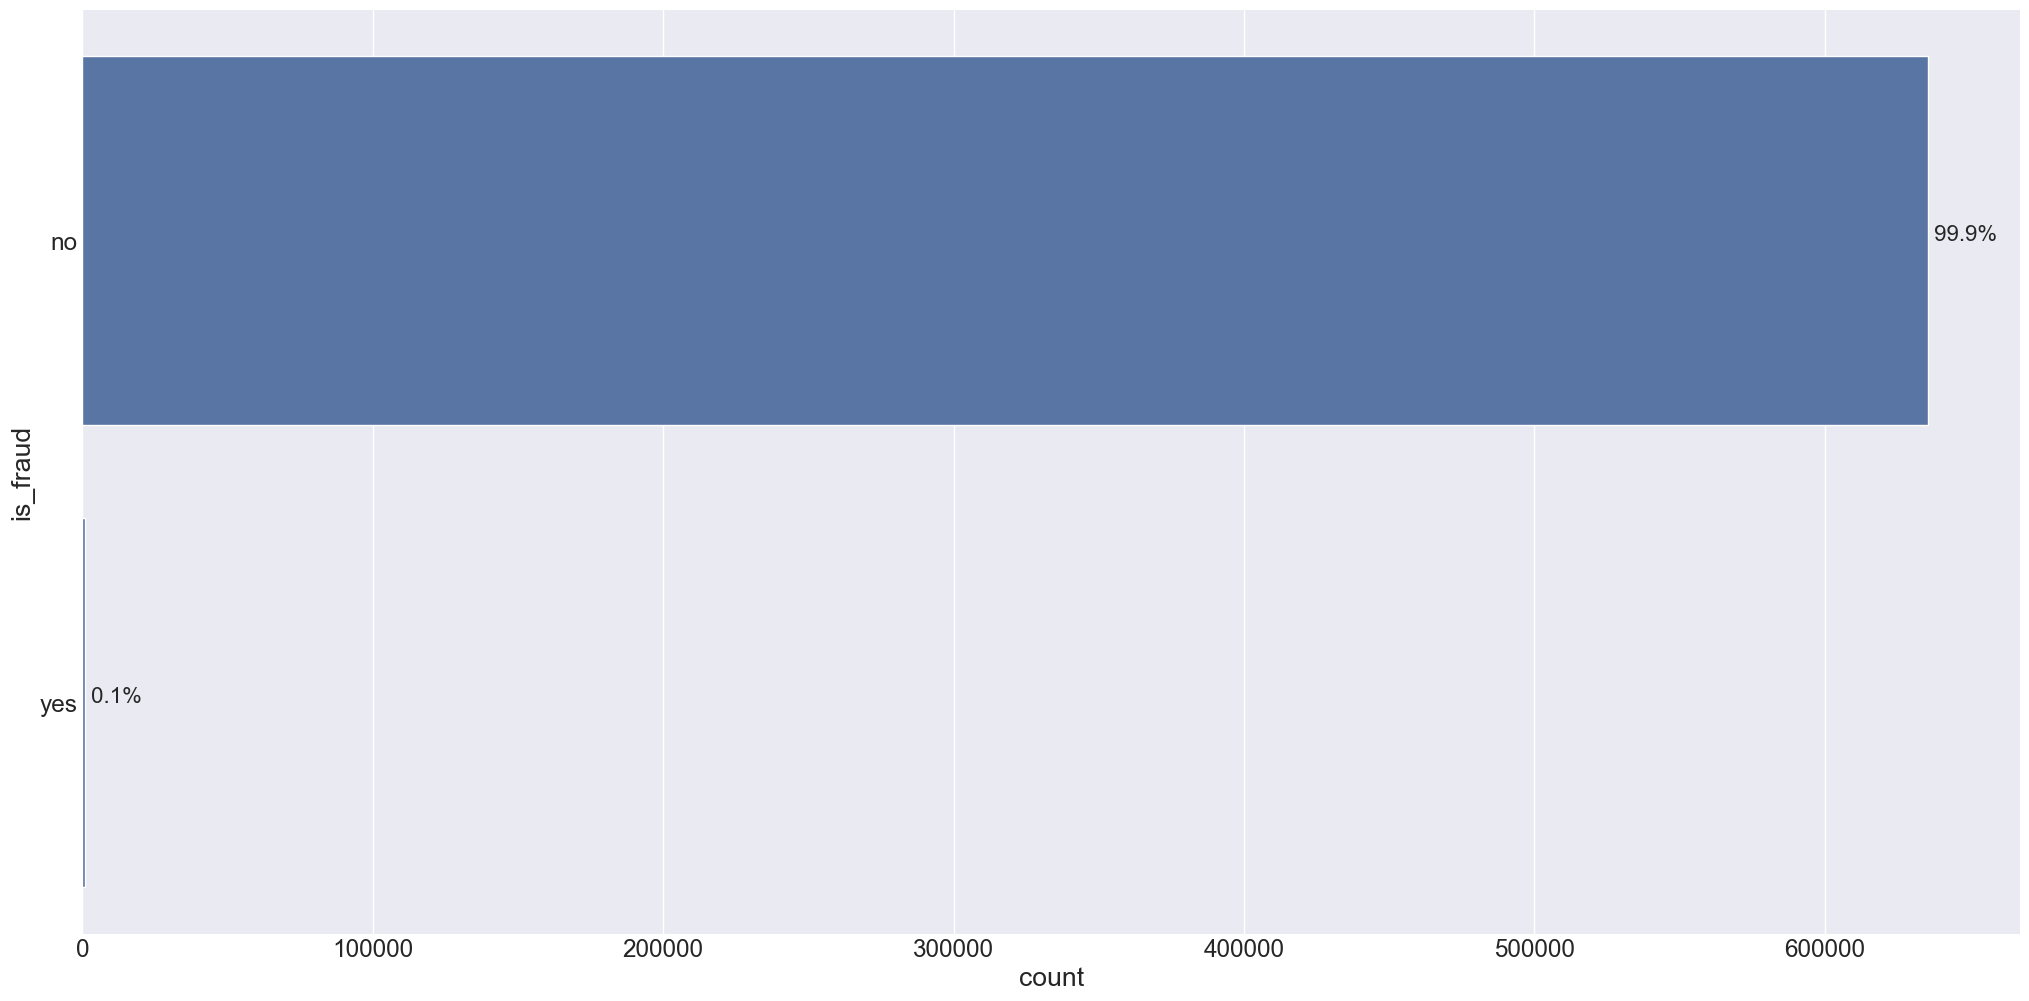

In [27]:
ax = sns.countplot(y='is_fraud', data=df4);

total = df4['is_fraud'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### 4.1.2 Numerical Variables

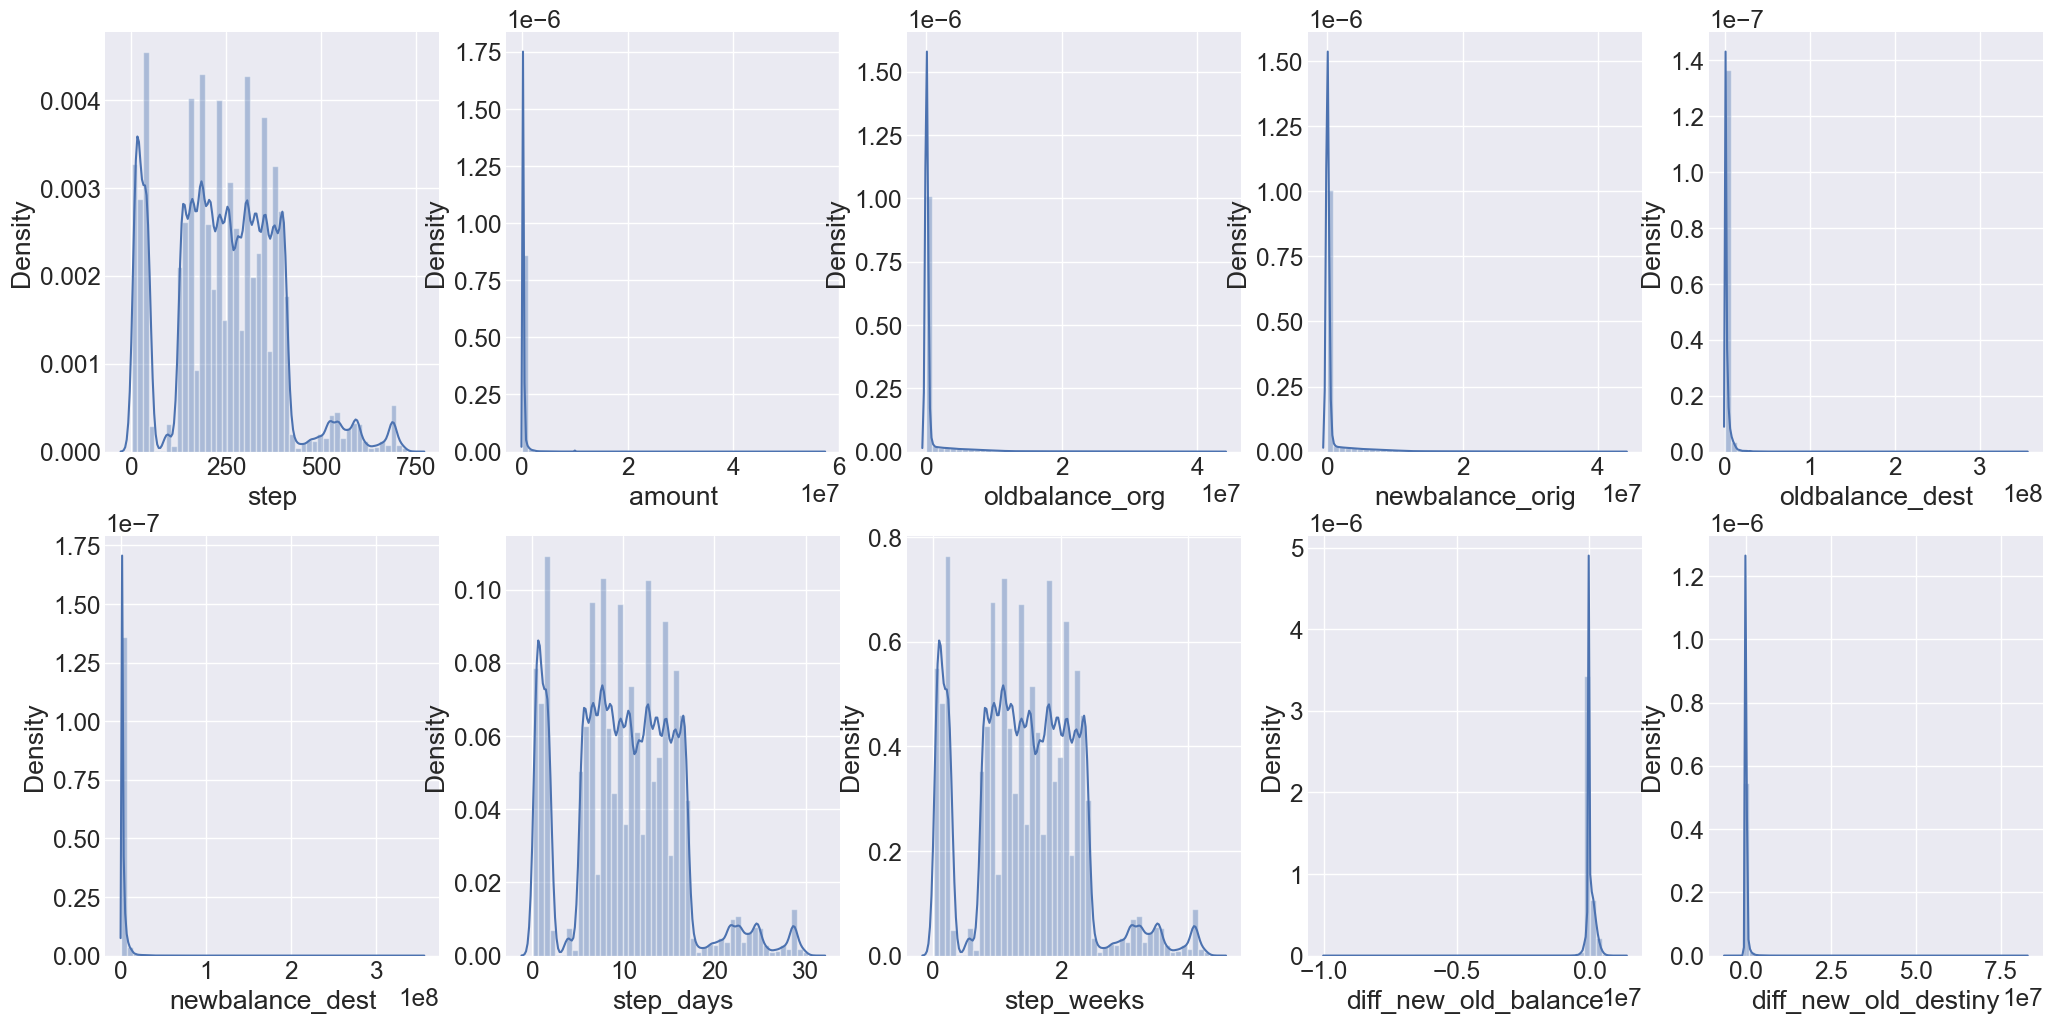

In [28]:
num_attributes = df4.select_dtypes(exclude='object')
columns = num_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(2, 5, j)
    sns.distplot(num_attributes[column]);

    j += 1

### 4.1.3 Categorical Variables

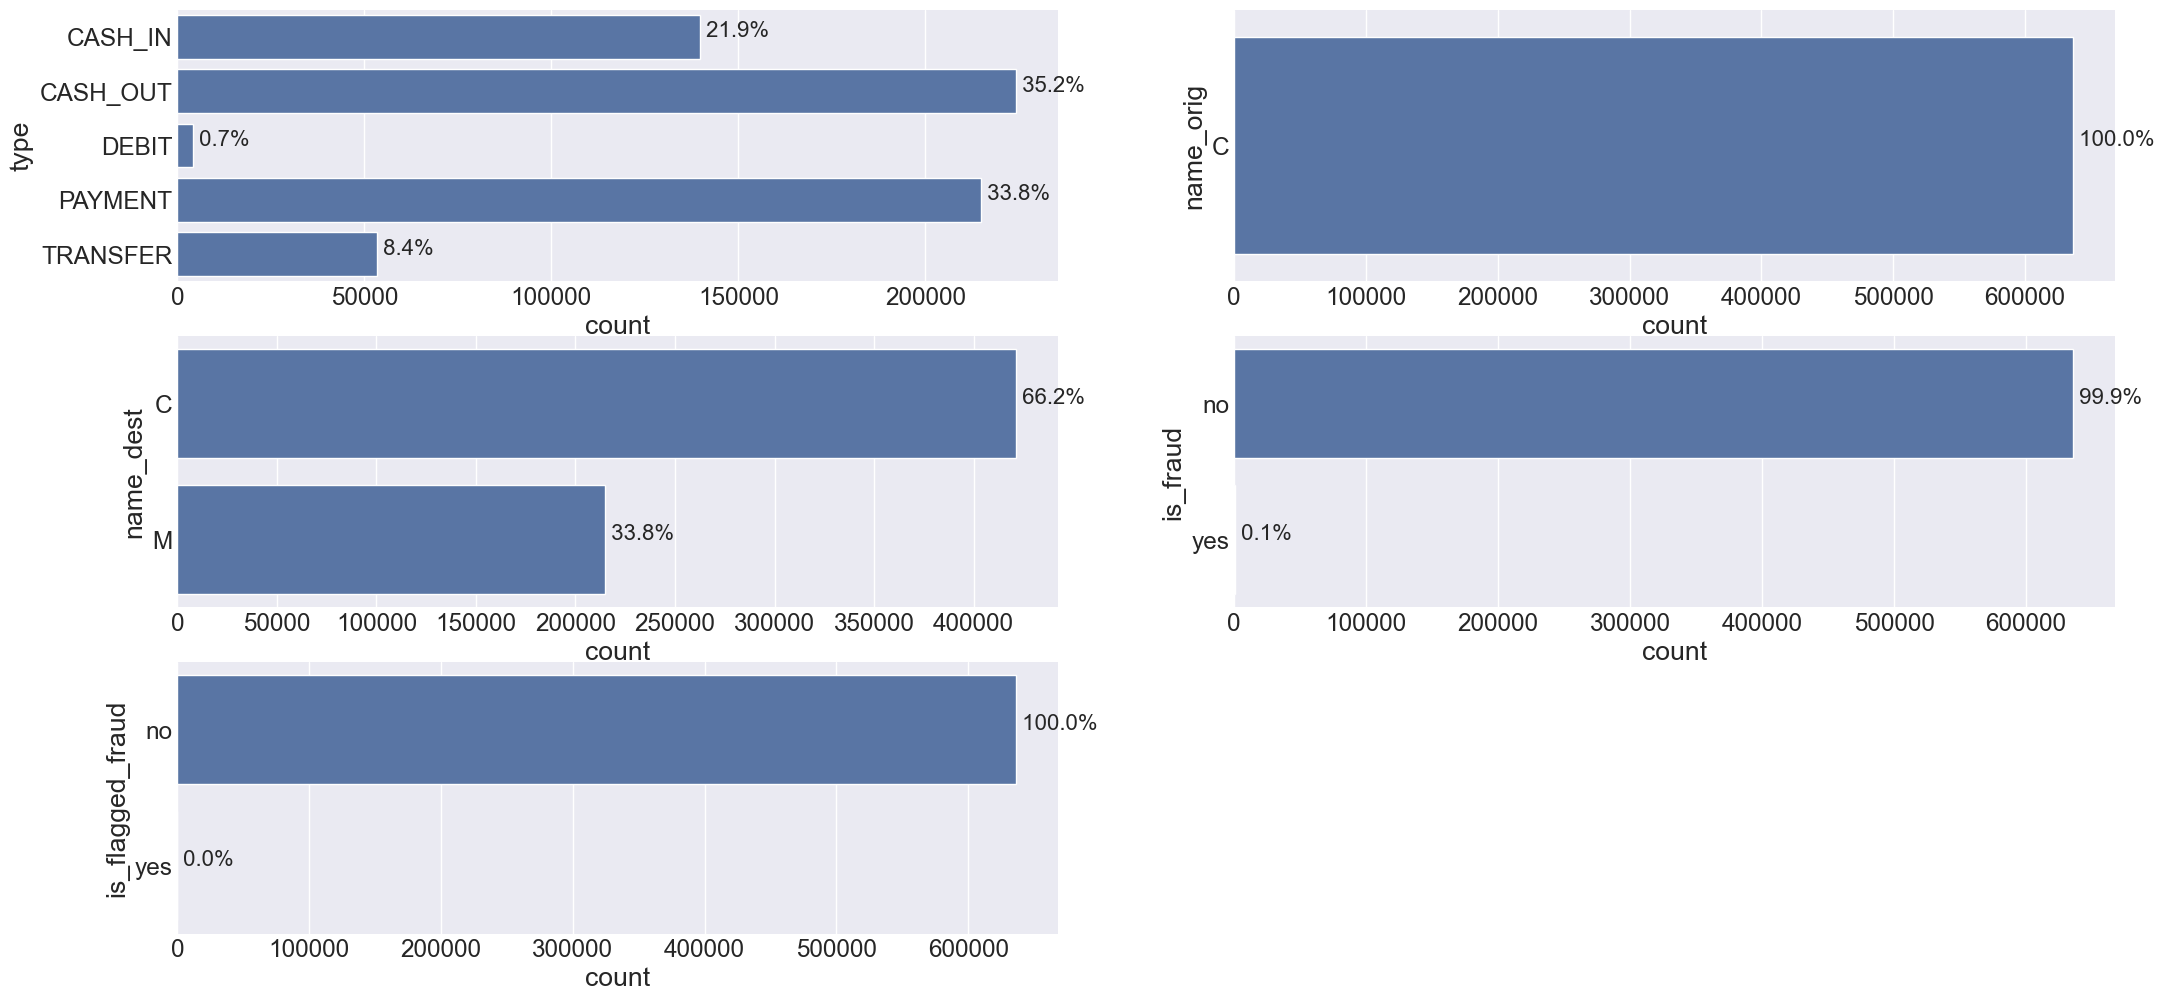

In [29]:
cat_attributes = df4.select_dtypes(include='object')
columns = cat_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(3, 2, j)
    ax = sns.countplot(y=column, data=cat_attributes)

    total = cat_attributes[column].size
    for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

    j += 1

## 4.2 Bivariate Analysis

### H1 The majority fraud transiction occours for the same user.
**TRUE:** The same user origem and destiny has got the same inital letter.

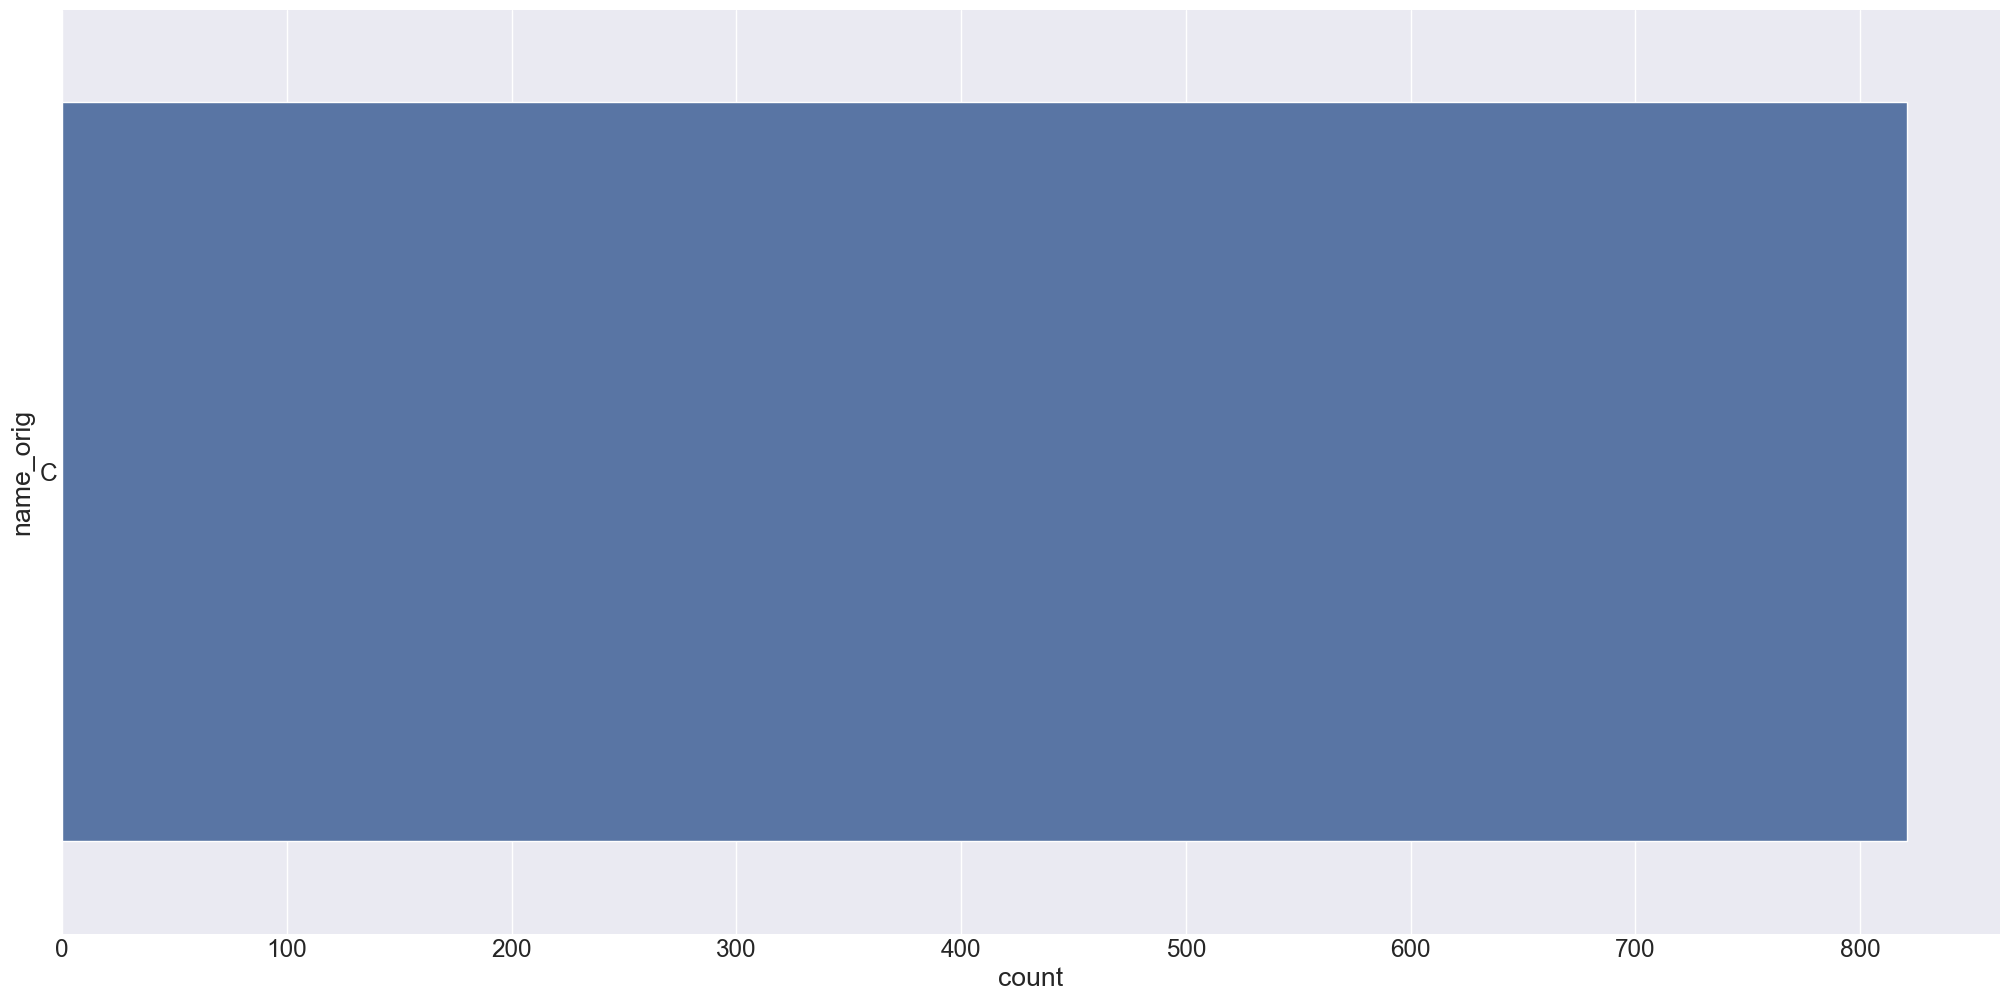

In [30]:
aux1 = df4[df4['is_fraud'] == 'yes']
sns.countplot(y='name_orig', data=aux1);

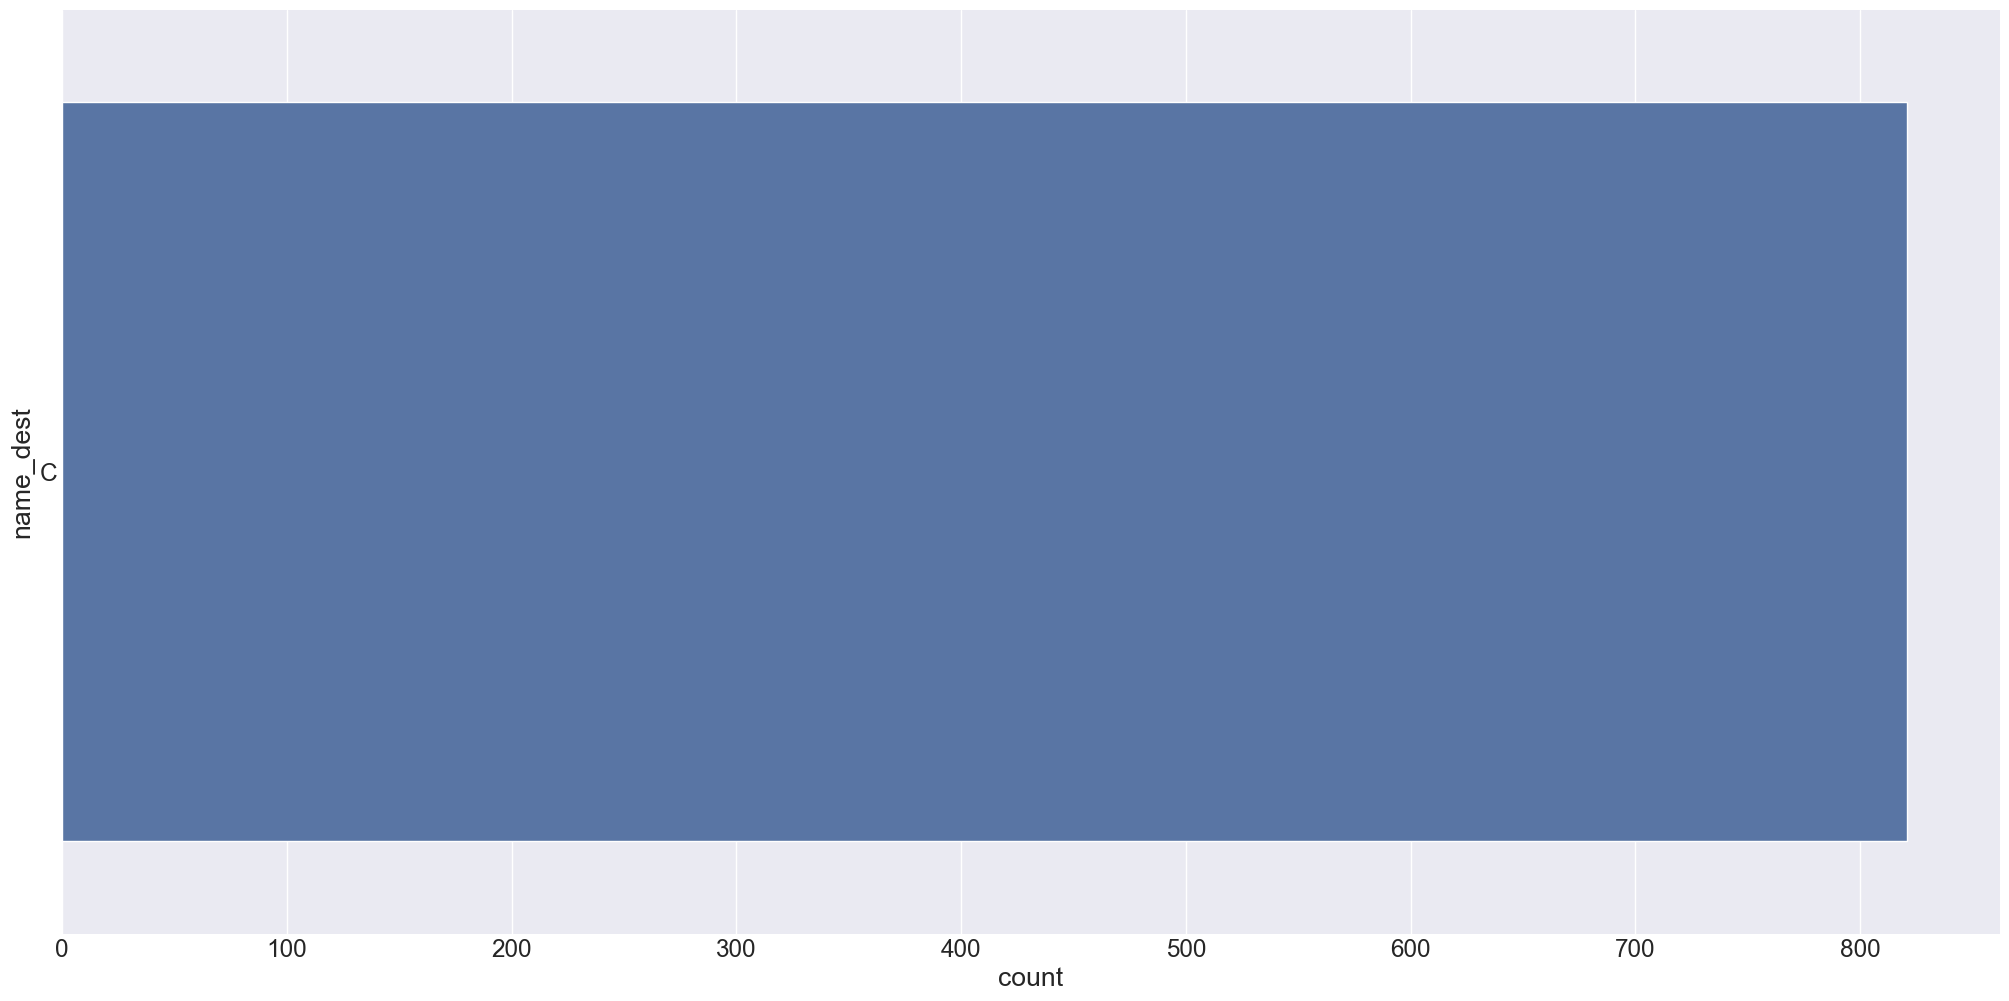

In [31]:
sns.countplot(y='name_dest', data=aux1);

### H2 All the fraud amount is greater than 10.000.

**TRUE:** The values are greater than 10.000. But it's important to note that the no-fraud values is greater than 100.000 also.

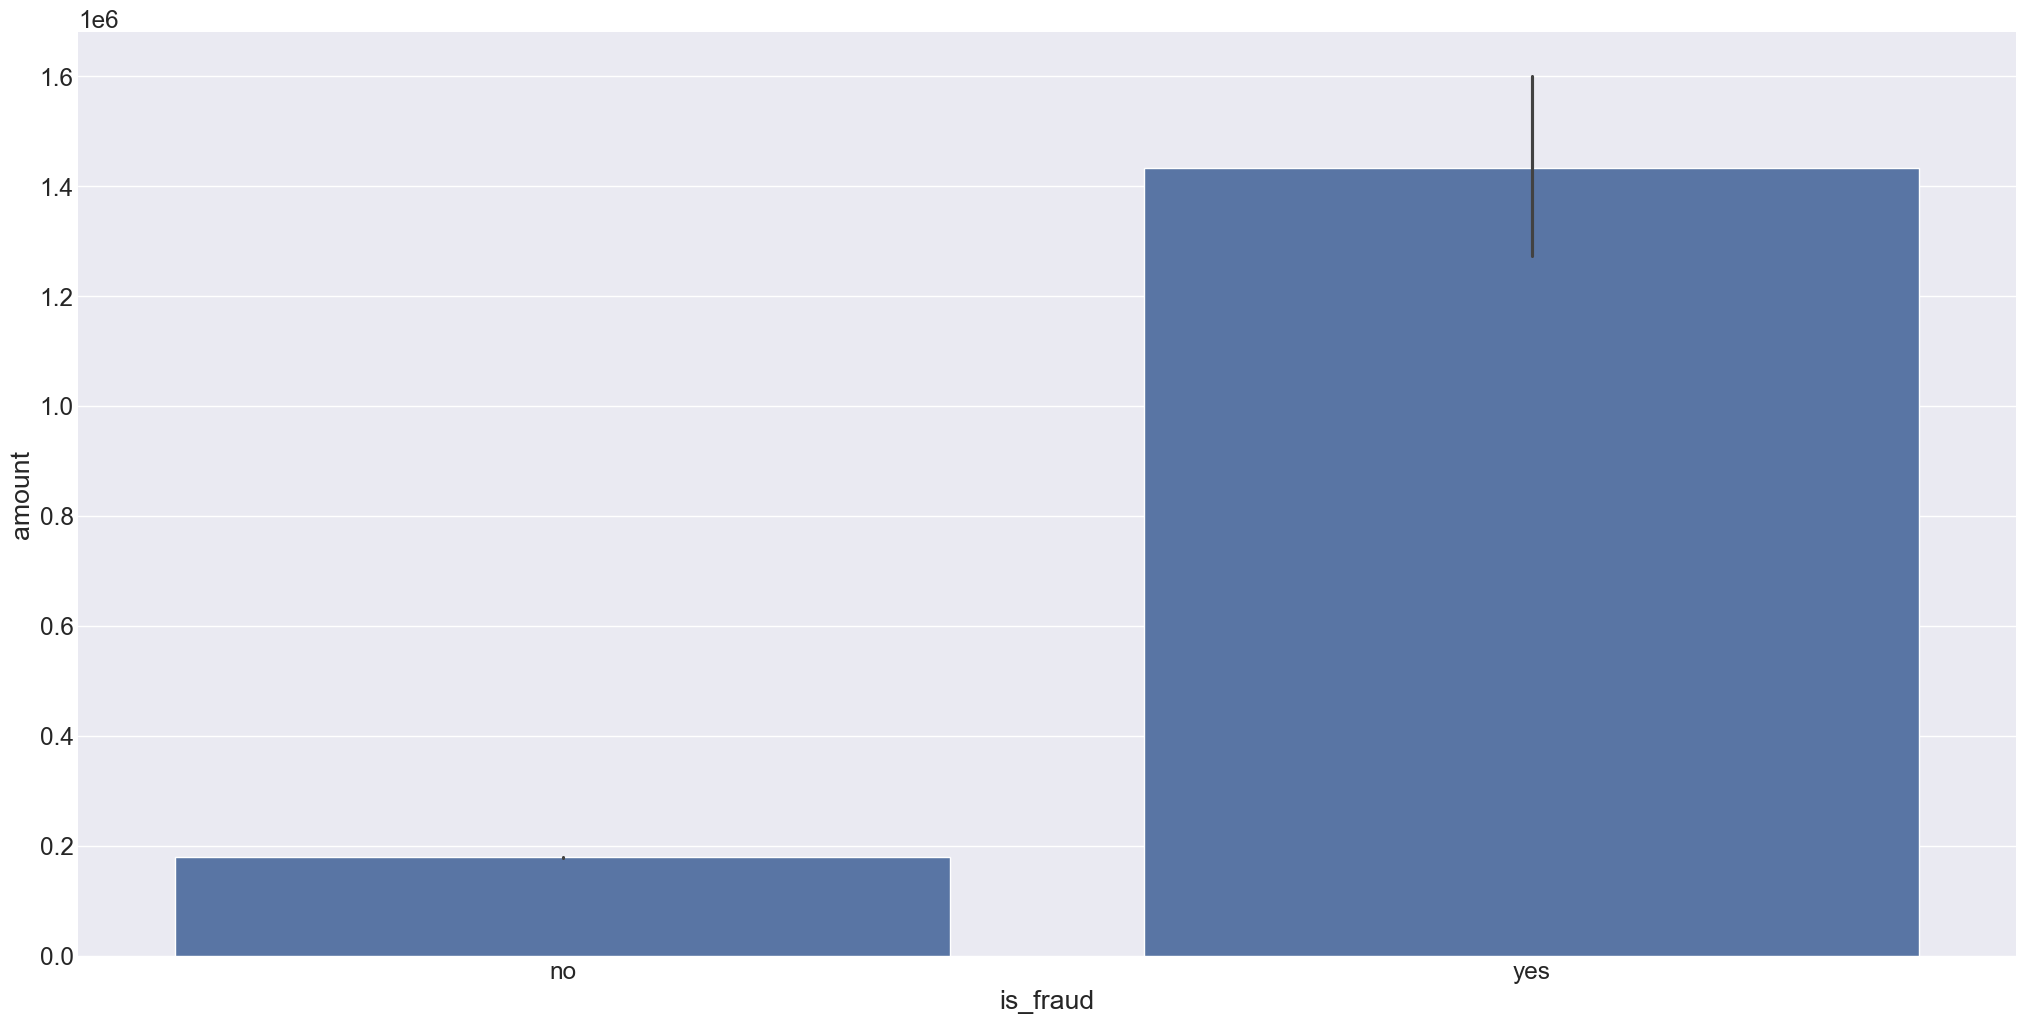

In [32]:
sns.barplot(y='amount', x='is_fraud', data=df4);

### H3 60% of fraud transaction occours using cash-out-type method.

**FALSE:** The fraud transaction occours in transfer and cash-out type. However they're almost the same value.

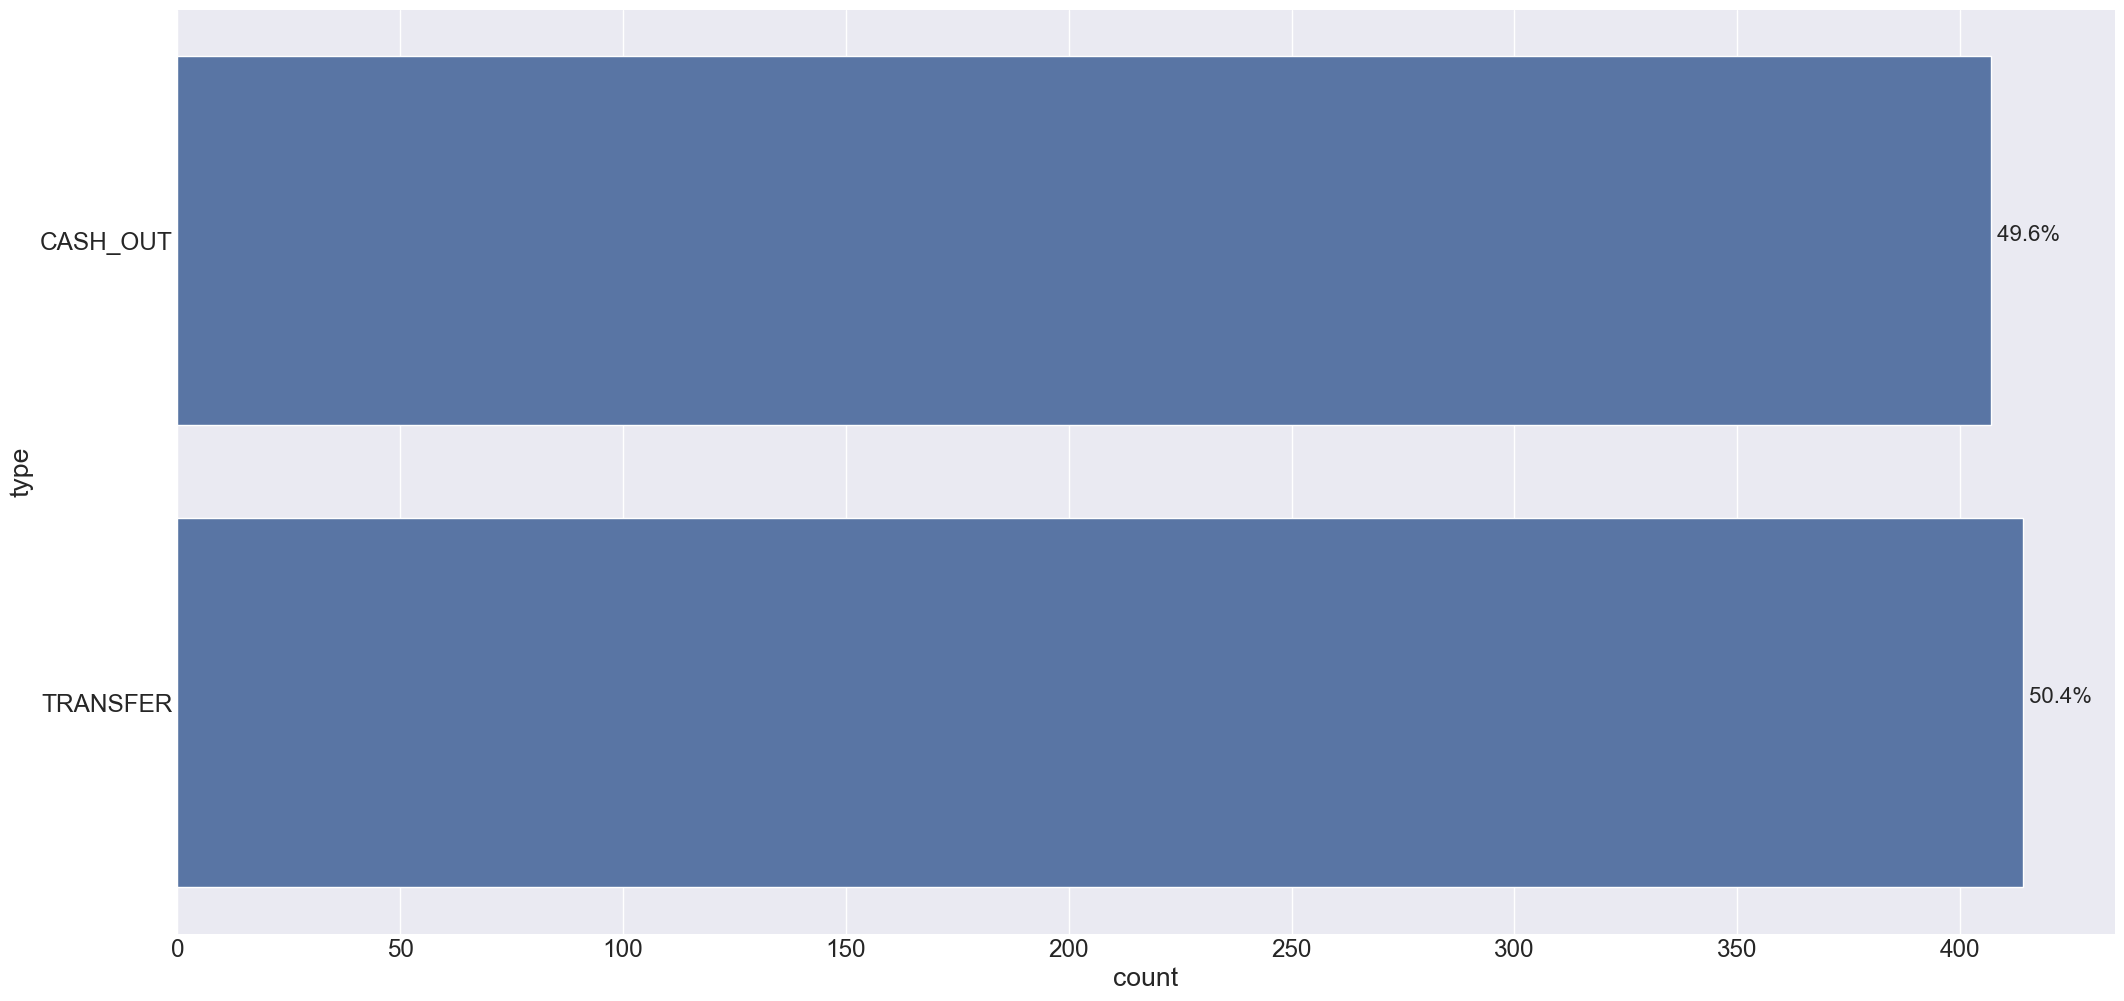

In [33]:
aux1 = df4[df4['is_fraud'] == 'yes']
ax = sns.countplot(y='type', data=aux1)

total = aux1['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

To see the complete transiction-type and I'll plot them here.

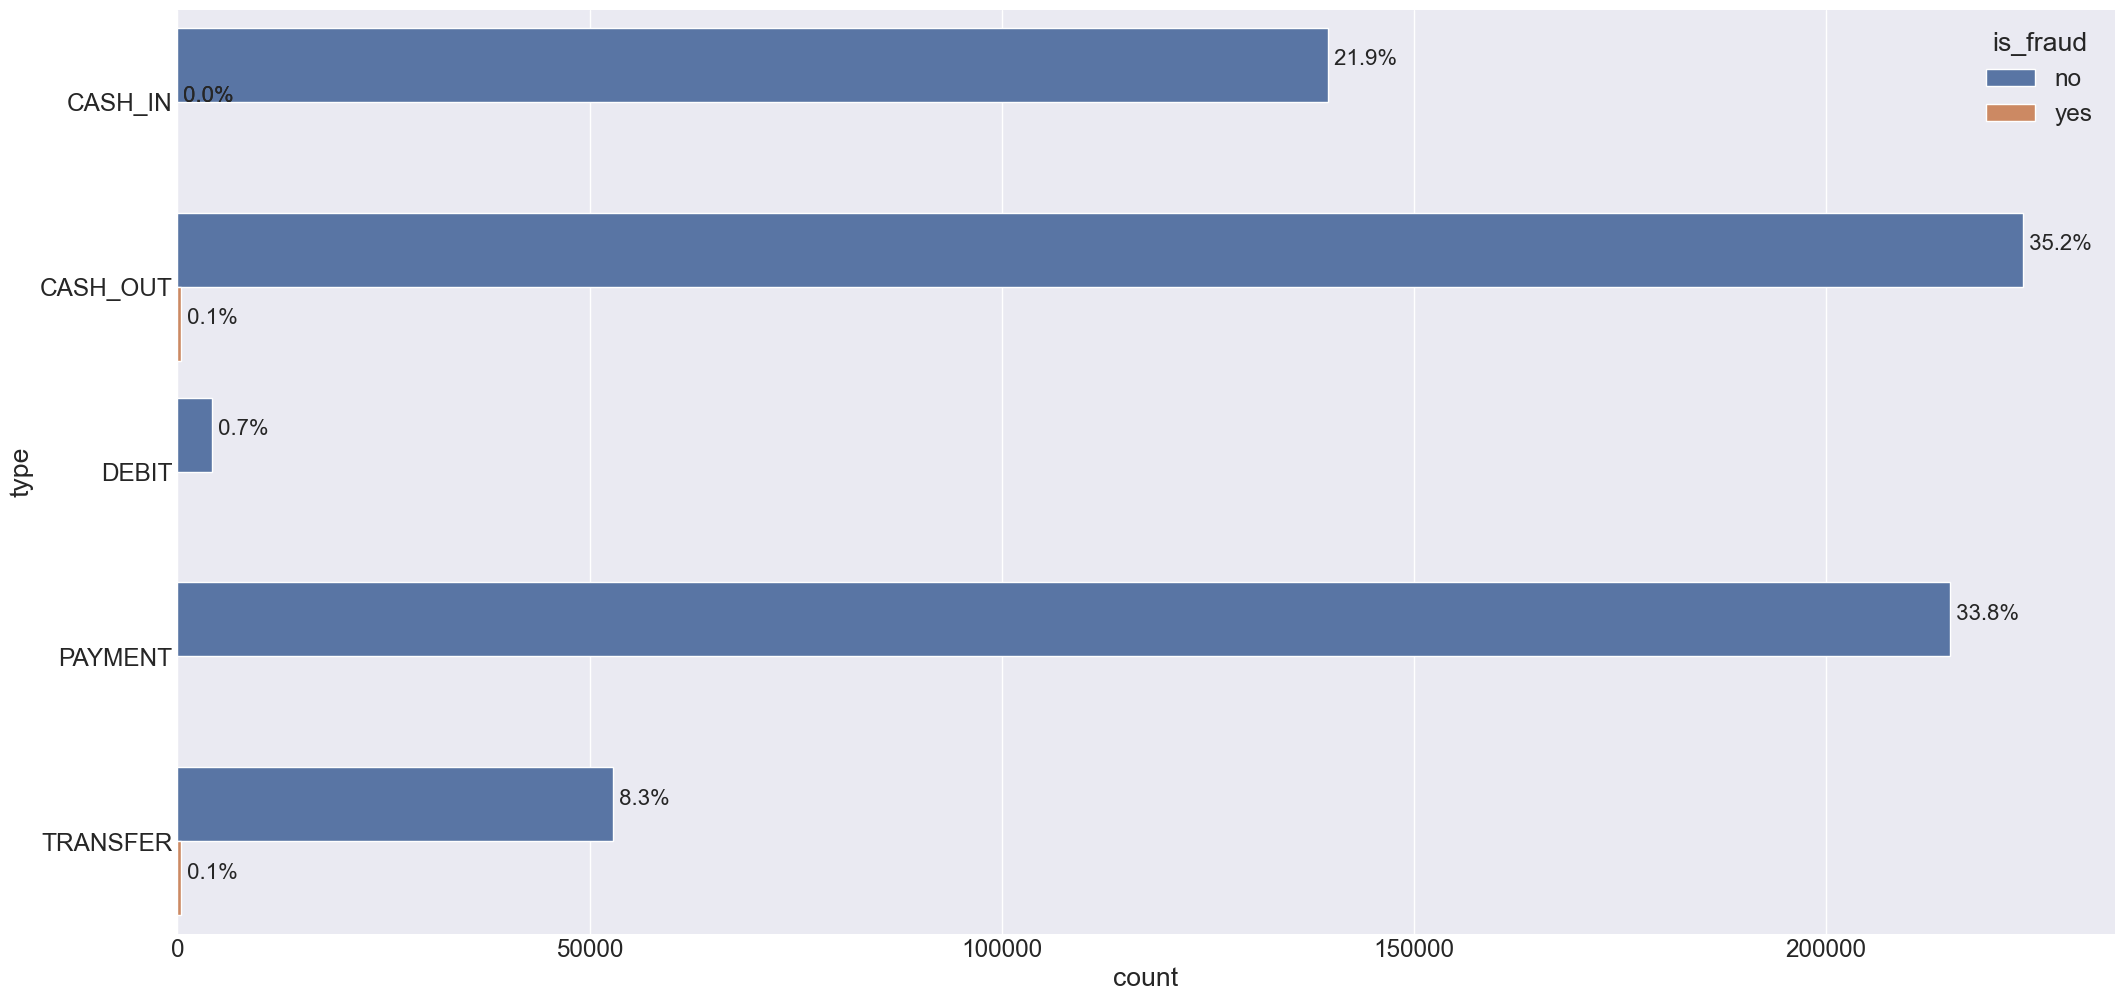

In [34]:
ax = sns.countplot(y='type', hue='is_fraud', data=df4)

total = df4['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### H4 Values greater than 100.000 occours using transfers-type method.

**FALSE:** The majority transactions occours in trasnfer-type, however transactions greater than 100.000 occour in cash-out and cash-in too.

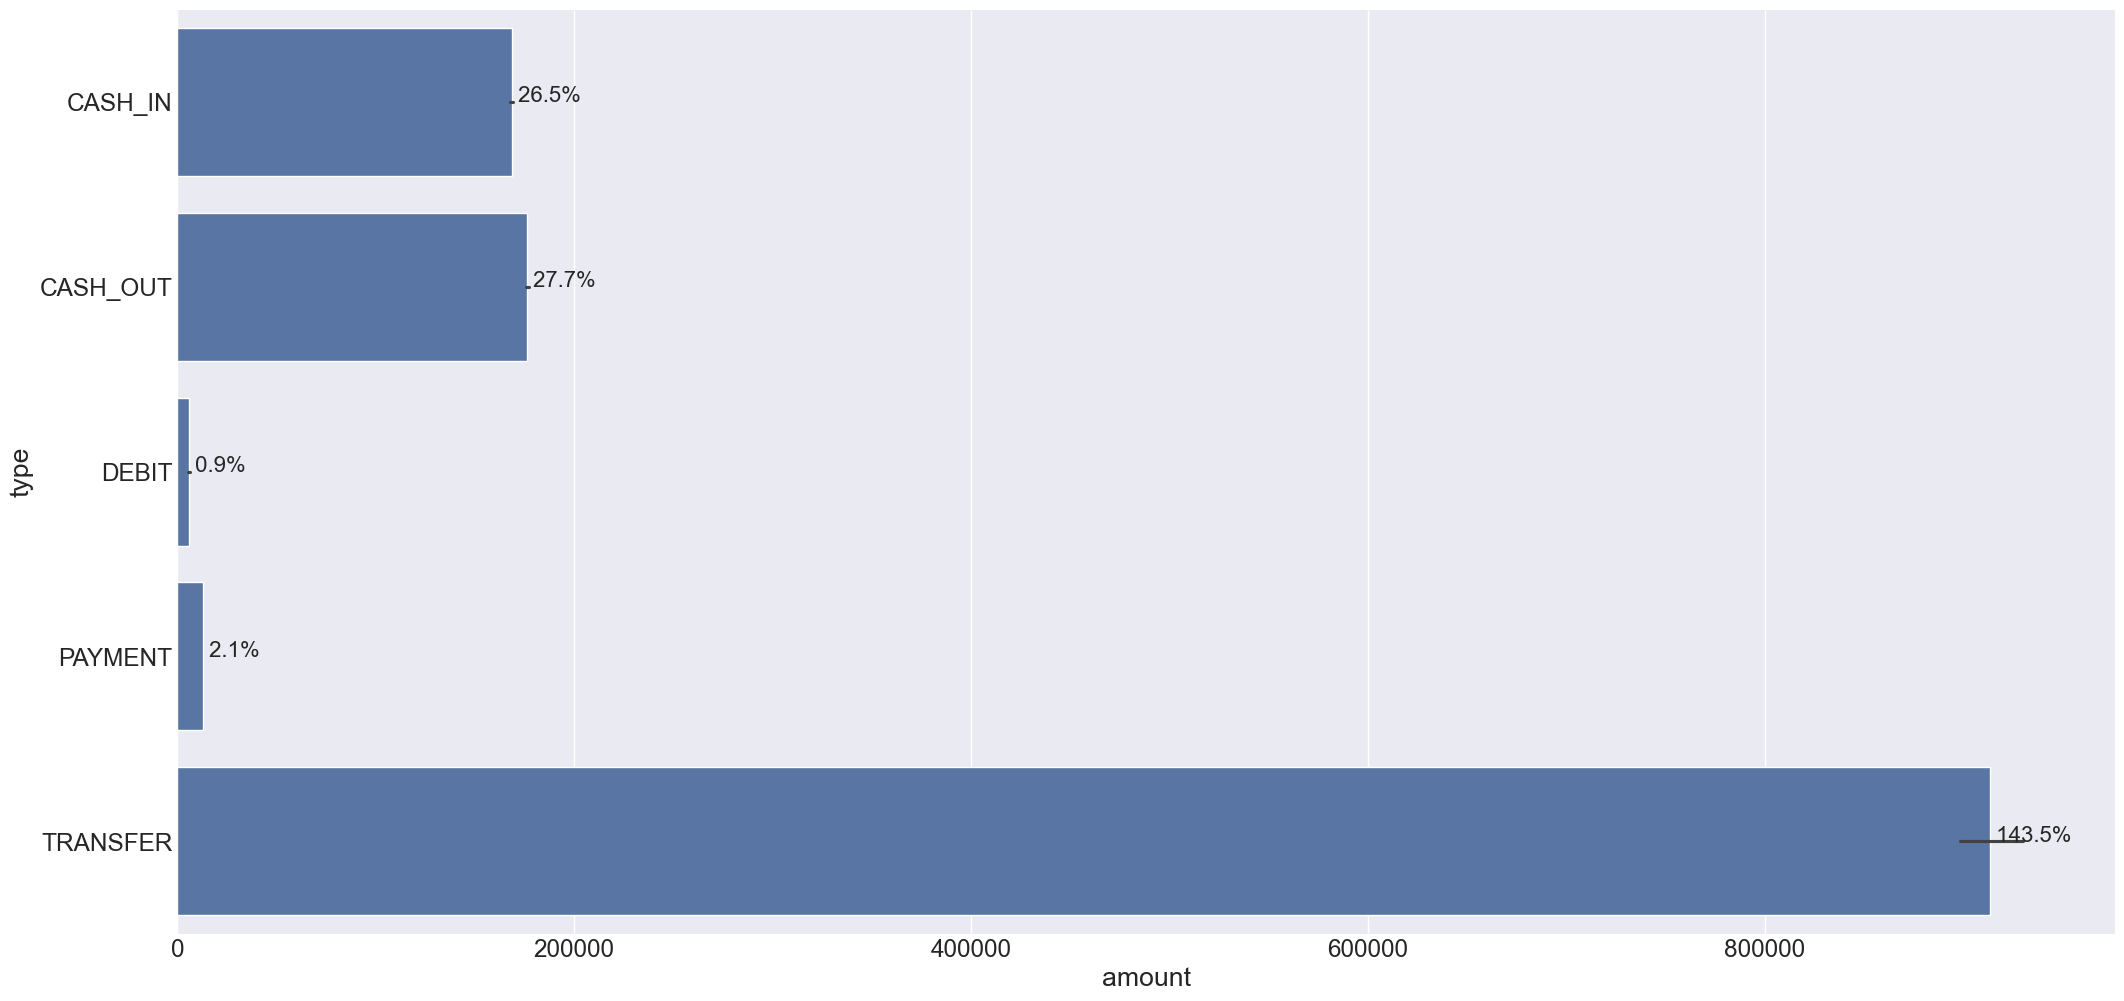

In [35]:
ax = sns.barplot(y='type', x='amount', data=df4);

total = df4['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### H5 Fraud transactions occours at least in 3 days.

**TRUE:** The values for transactions and days in fraud aren't similar.

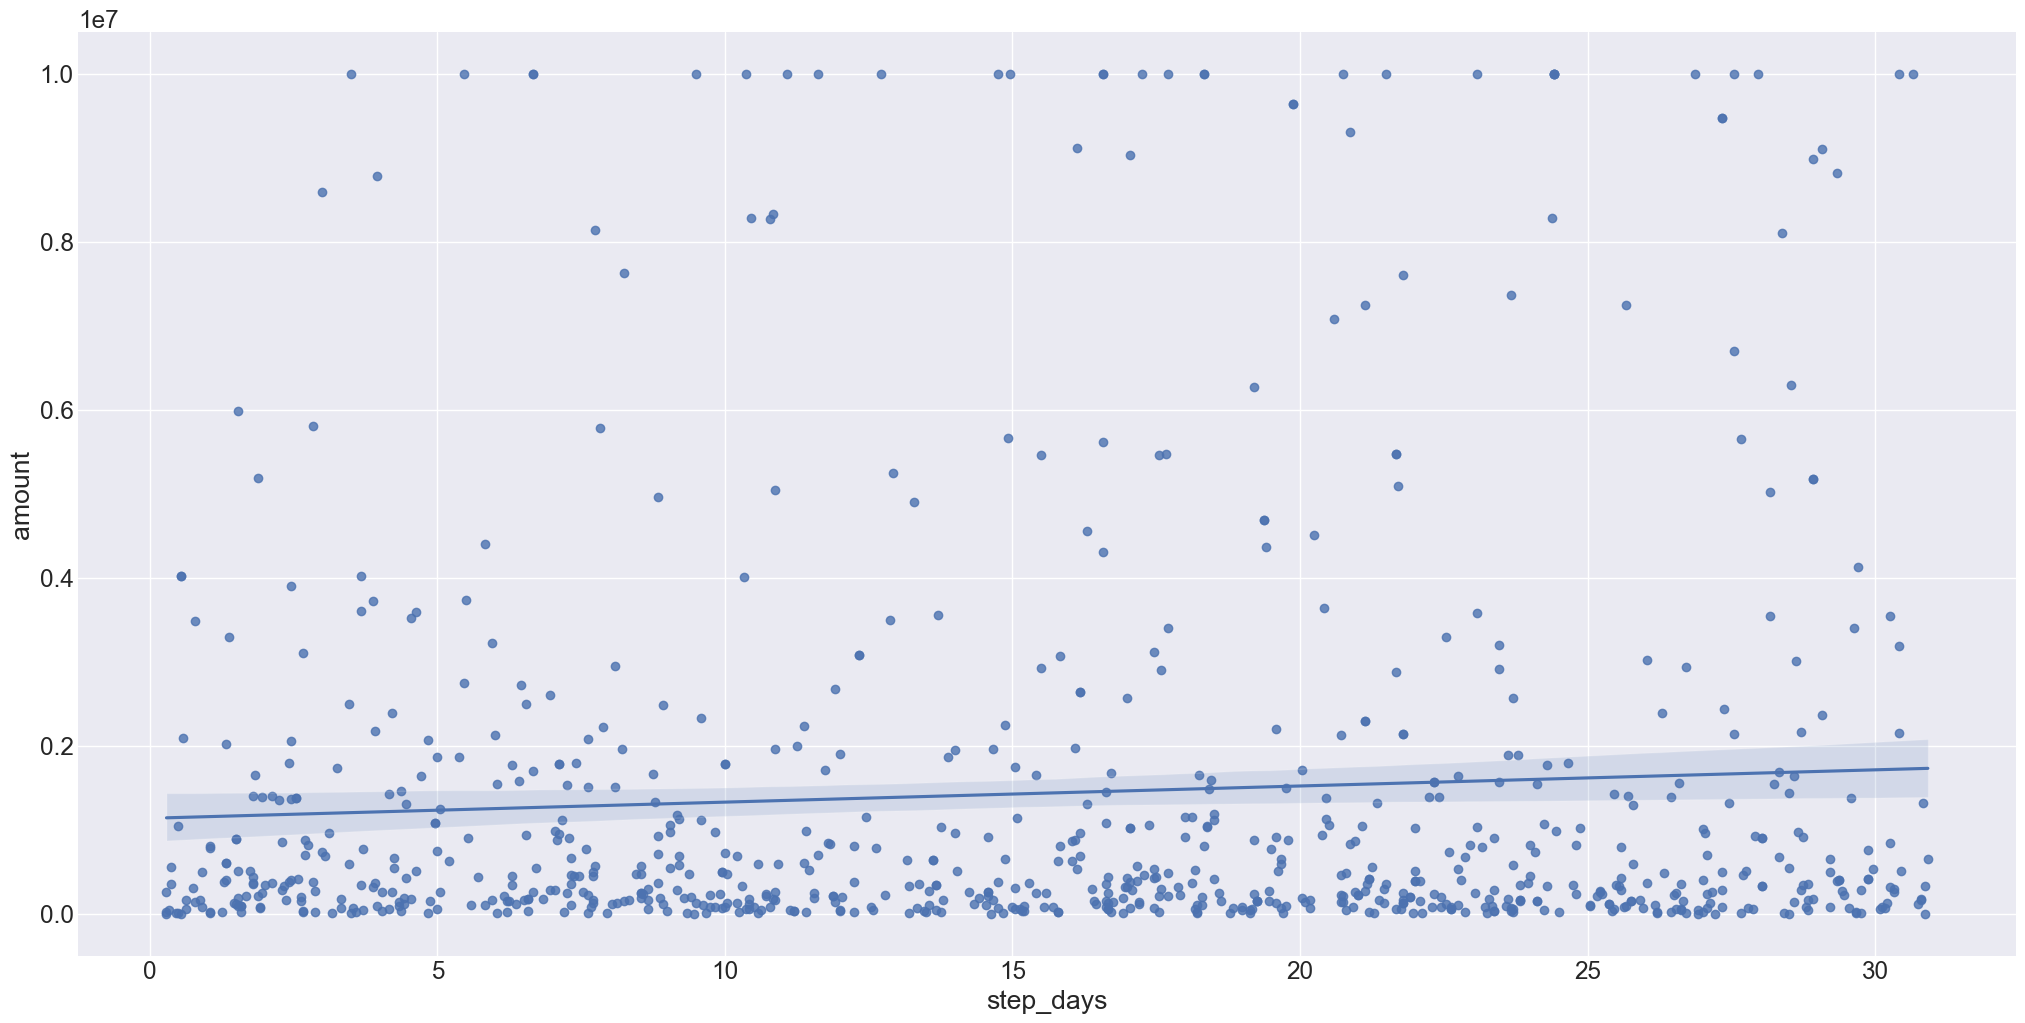

In [36]:
aux1 = df4[df4['is_fraud'] == 'yes']
sns.regplot(x='step_days', y='amount', data=aux1);

## 4.3 Multivariaty Analysis

### 4.3.1 Numerical Analysis

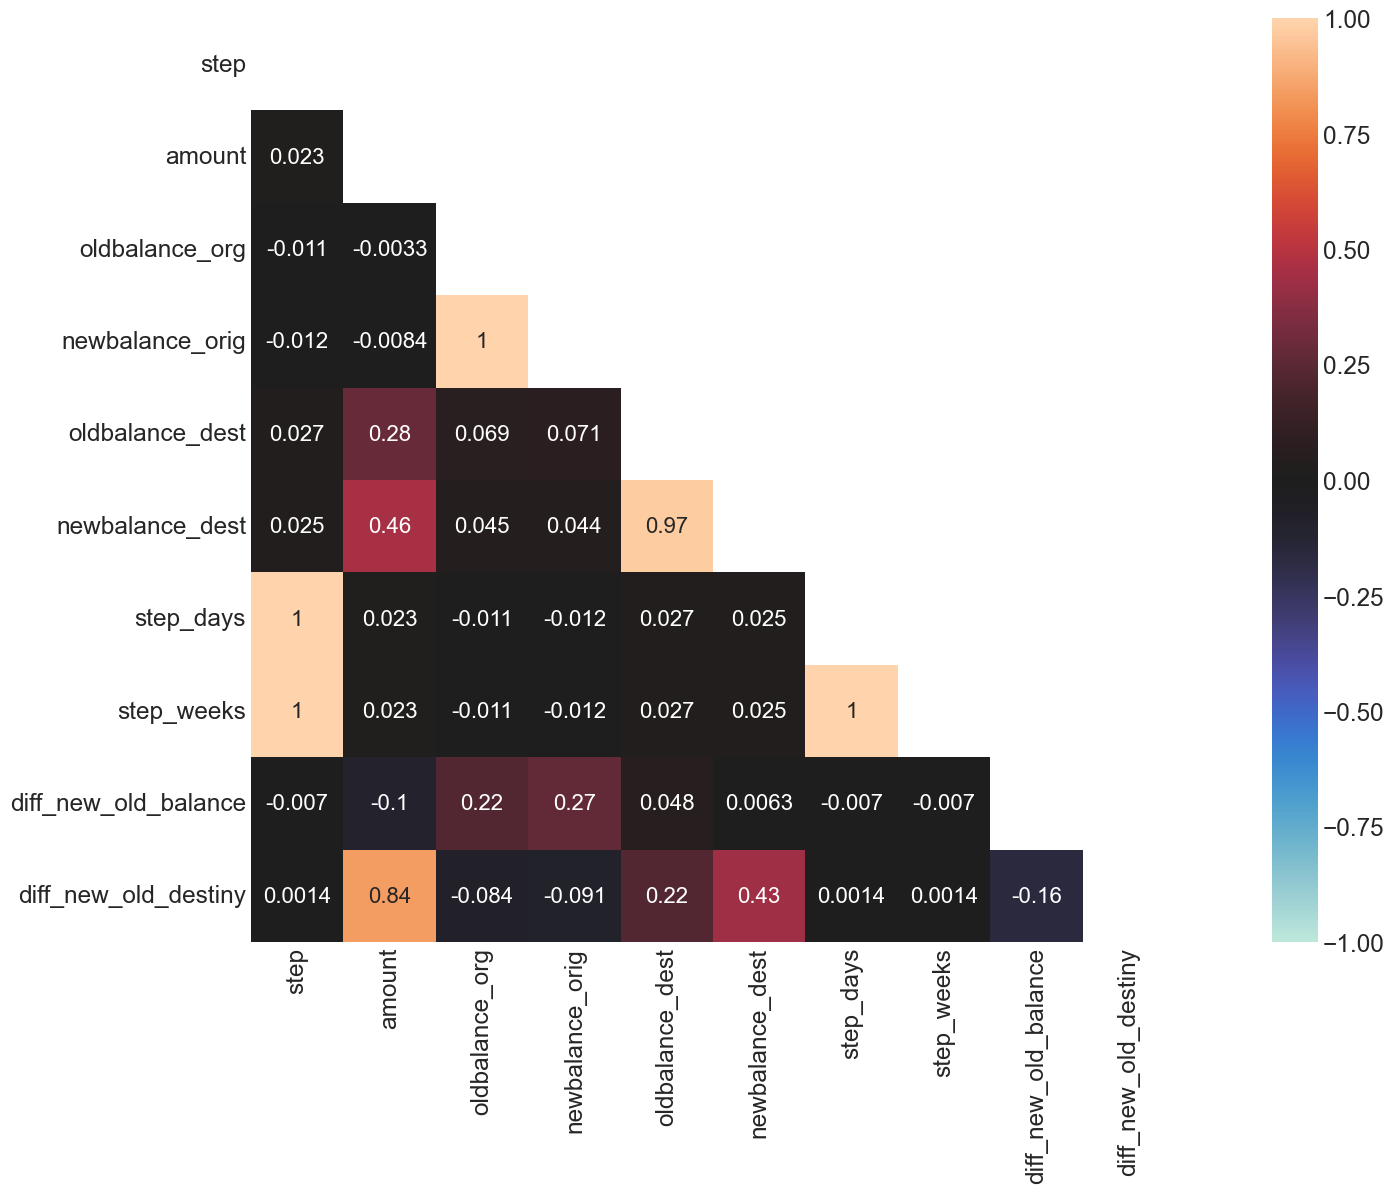

In [37]:
corr = num_attributes.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True)

### 4.3.2 Categorical Variables

In [38]:
dict_corr = {}
columns = cat_attributes.columns.tolist()

for column in columns:
    dict_corr[column] = {}

    for column2 in columns:
        dict_corr[column][column2] = calcCramerV(cat_attributes[column], cat_attributes[column2])

corr = pd.DataFrame(dict_corr)

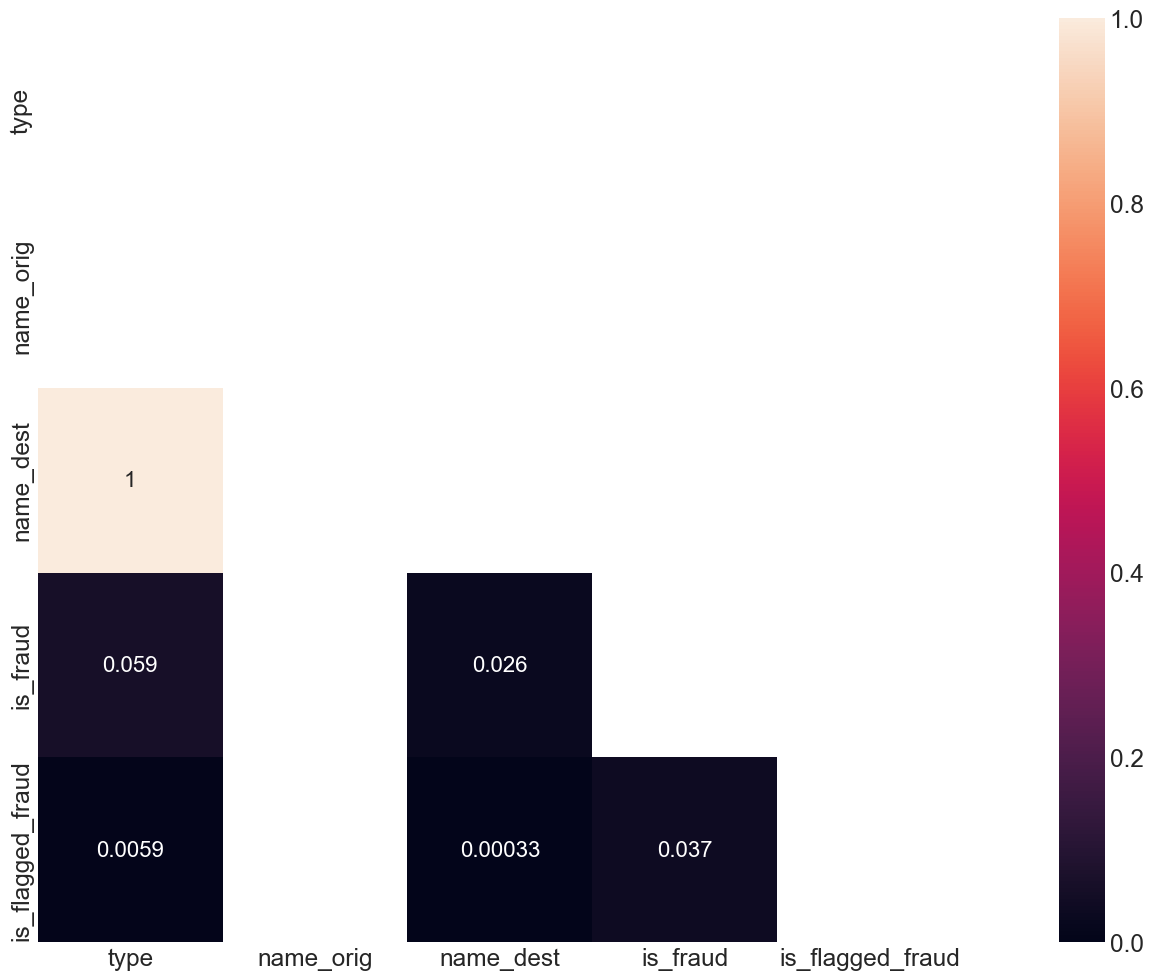

In [39]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=0, vmax=1, square=True)

# 5.0 Data Preparation

In [40]:
df5 = df4.copy()

## 5.1 Spliting into Train, Valid and Test

In [41]:
df5.dropna(inplace=True)

In [42]:
X = df5.drop(columns=['is_fraud', 'is_flagged_fraud', 'name_orig', 'name_dest',
                      'step_weeks', 'step_days'], axis=1)
y = df5['is_fraud'].map({'yes': 1, 'no': 0})

In [43]:
# spliting into temp and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=.2, stratify=y)

In [44]:
# spliting into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=.2, stratify=y_temp)

## 5.2 One Hot Encoder

In [45]:
ohe = OneHotEncoder(cols=['type'], use_cat_names=True)

X_train = ohe.fit_transform(X_train)
X_valid = ohe.transform(X_valid)

X_temp = ohe.fit_transform(X_temp)
X_test = ohe.transform(X_test)

## 5.3 Rescaling

In [46]:
num_columns = ['amount', 'oldbalance_org', 'newbalance_orig', 'oldbalance_dest', 'newbalance_dest',
               'diff_new_old_balance', 'diff_new_old_destiny']
mm = MinMaxScaler()
X_params = X_temp.copy()

X_train[num_columns] = mm.fit_transform(X_train[num_columns])
X_valid[num_columns] = mm.transform(X_valid[num_columns])

X_params[num_columns] = mm.fit_transform(X_temp[num_columns])
X_test[num_columns] = mm.transform(X_test[num_columns])

# 6.0 Feature Selection

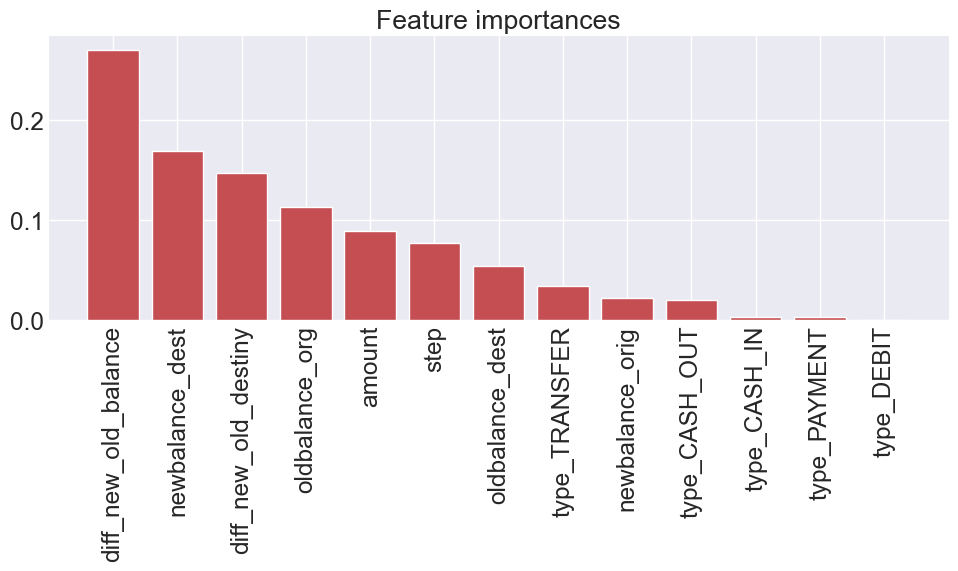

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

clf.fit(X_train, y_train)

importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

num_features = X_train.shape[1]

feature_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices],
       color="r", align="center")
plt.xticks(range(num_features), feature_names[indices], rotation=90)
plt.xlim([-1, num_features])
plt.tight_layout()
plt.show()

In [48]:
final_columns_selected = ['step', 'oldbalance_org',
                          'newbalance_orig', 'newbalance_dest',
                          'diff_new_old_balance', 'diff_new_old_destiny',
                          'type_TRANSFER']

# 7.0 Machine Learning Modeling

In [49]:
X_train_cs = X_train[final_columns_selected]
X_valid_cs = X_valid[final_columns_selected]

X_temp_cs = X_temp[final_columns_selected]
X_test_cs = X_test[final_columns_selected]

X_params_cs = X_params[final_columns_selected]

In [50]:
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [52]:
input_dim = X_train_cs.shape[1]
encoding_dim = 14
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(1, activation='sigmoid')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

nb_epoch = 10
batch_size = 32
autoencoder.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.keras",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train_cs, y_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test_cs, y_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/10
12726/12726 ━━━━━━━━━━━━━━━━━━━━ 4s 320us/step - accuracy: 0.9987 - loss: 0.0426 - val_accuracy: 0.9987 - val_loss: 0.0283
Epoch 2/10
12726/12726 ━━━━━━━━━━━━━━━━━━━━ 4s 316us/step - accuracy: 0.9988 - loss: 0.0158 - val_accuracy: 0.9987 - val_loss: 0.0155
Epoch 3/10
12726/12726 ━━━━━━━━━━━━━━━━━━━━ 4s 315us/step - accuracy: 0.9987 - loss: 0.0220 - val_accuracy: 0.9987 - val_loss: 0.0360
Epoch 4/10
12726/12726 ━━━━━━━━━━━━━━━━━━━━ 4s 318us/step - accuracy: 0.9988 - loss: 0.0240 - val_accuracy: 0.9987 - val_loss: 0.0266
Epoch 5/10
12726/12726 ━━━━━━━━━━━━━━━━━━━━ 4s 315us/step - accuracy: 0.9987 - loss: 0.0246 - val_accuracy: 0.9987 - val_loss: 0.0227
Epoch 6/10
12726/12726 ━━━━━━━━━━━━━━━━━━━━ 4s 321us/step - accuracy: 0.9986 - loss: 0.0279 - val_accuracy: 0.9987 - val_loss: 0.0220
Epoch 7/10
12726/12726 ━━━━━━━━━━━━━━━━━━━━ 4s 320us/step - accuracy: 0.9987 - loss: 0.0276 - val_accuracy: 0.9987 - val_loss: 0.0175
Epoch 8/10
12726/12726 ━━━━━━━━━━━━━━━━━━━━ 4s 316us/step - ac

In [54]:
autoencoder = load_model('model.keras')

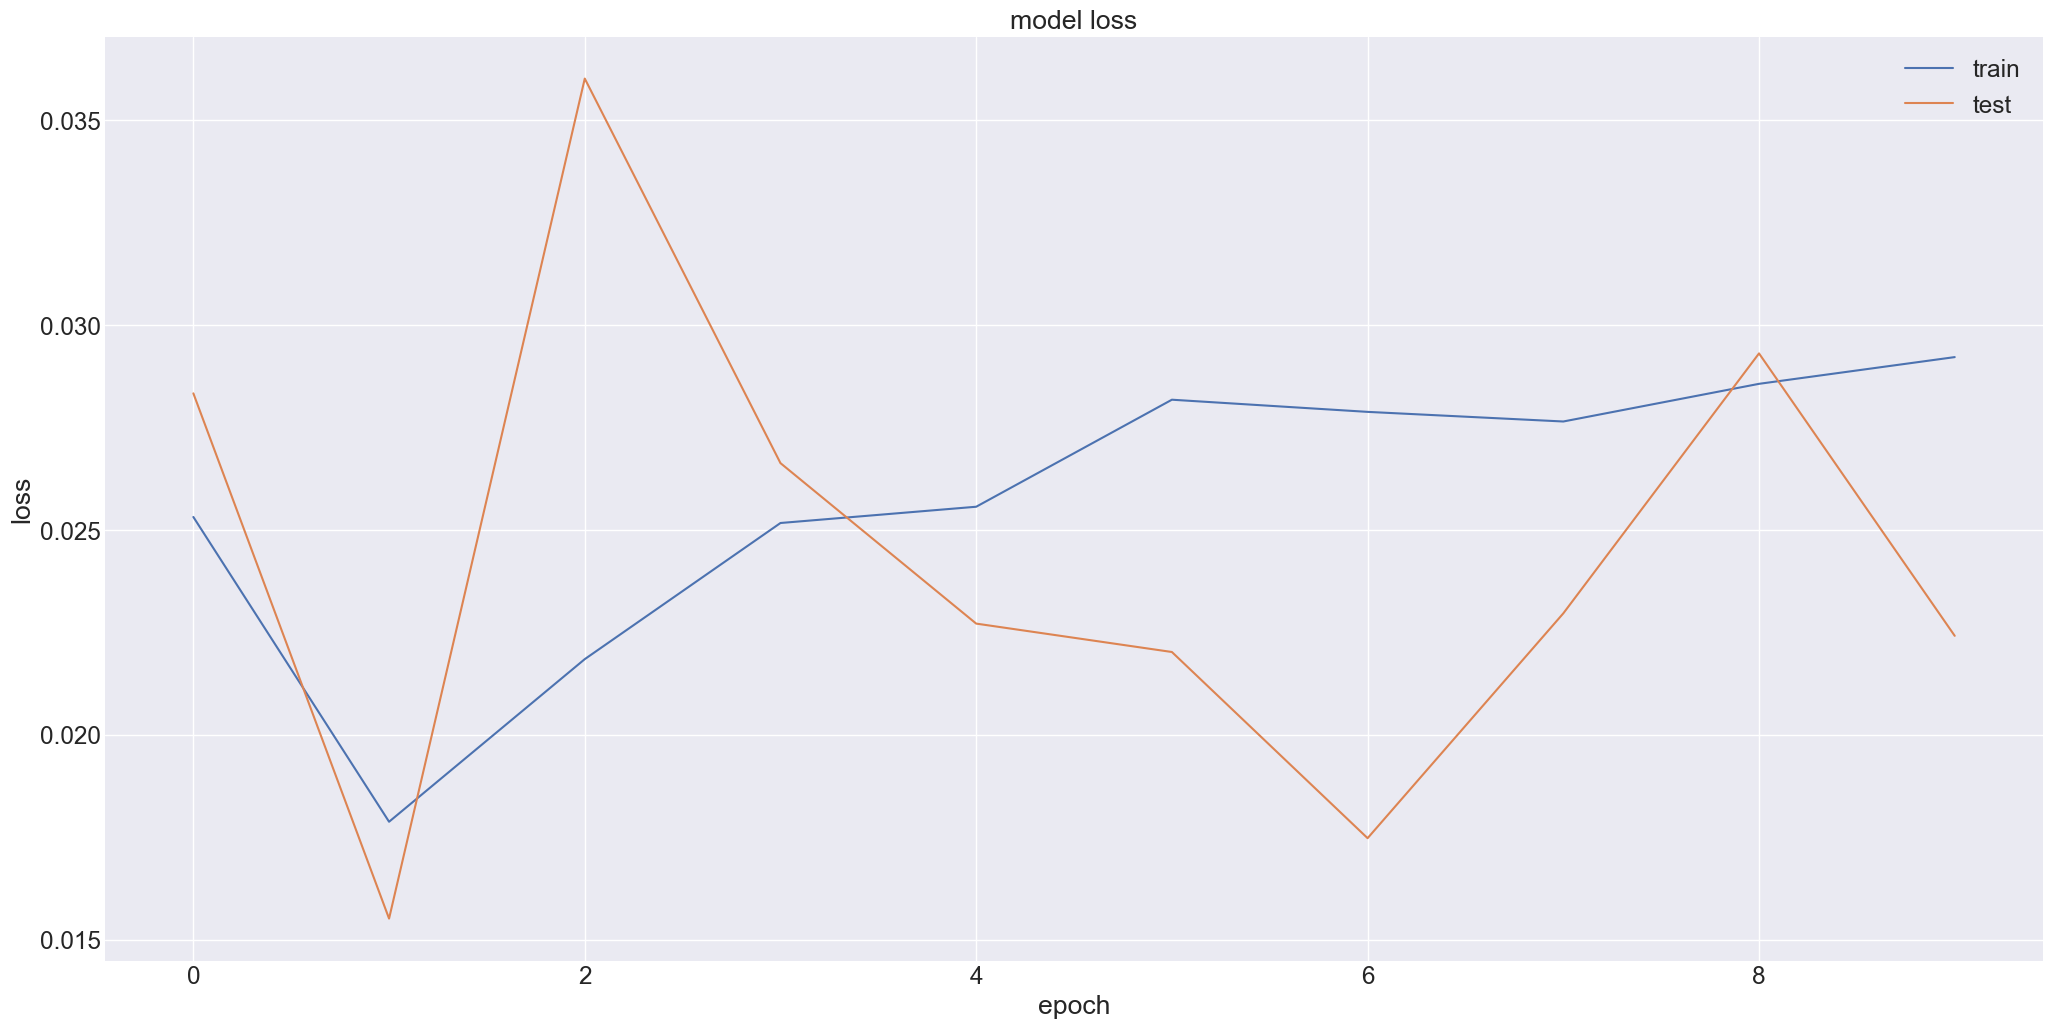

In [55]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [56]:
from sklearn.metrics import classification_report

predictions = autoencoder.predict(X_test_cs)
threshold = 0.5
predicted_classes = (predictions > threshold).astype('int')

print(classification_report(y_test, predicted_classes))

3977/3977 ━━━━━━━━━━━━━━━━━━━━ 1s 155us/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127089
           1       0.00      0.00      0.00       164

    accuracy                           1.00    127253
   macro avg       0.50      0.50      0.50    127253
weighted avg       1.00      1.00      1.00    127253



**ROC AUC score**

3977/3977 ━━━━━━━━━━━━━━━━━━━━ 1s 151us/step


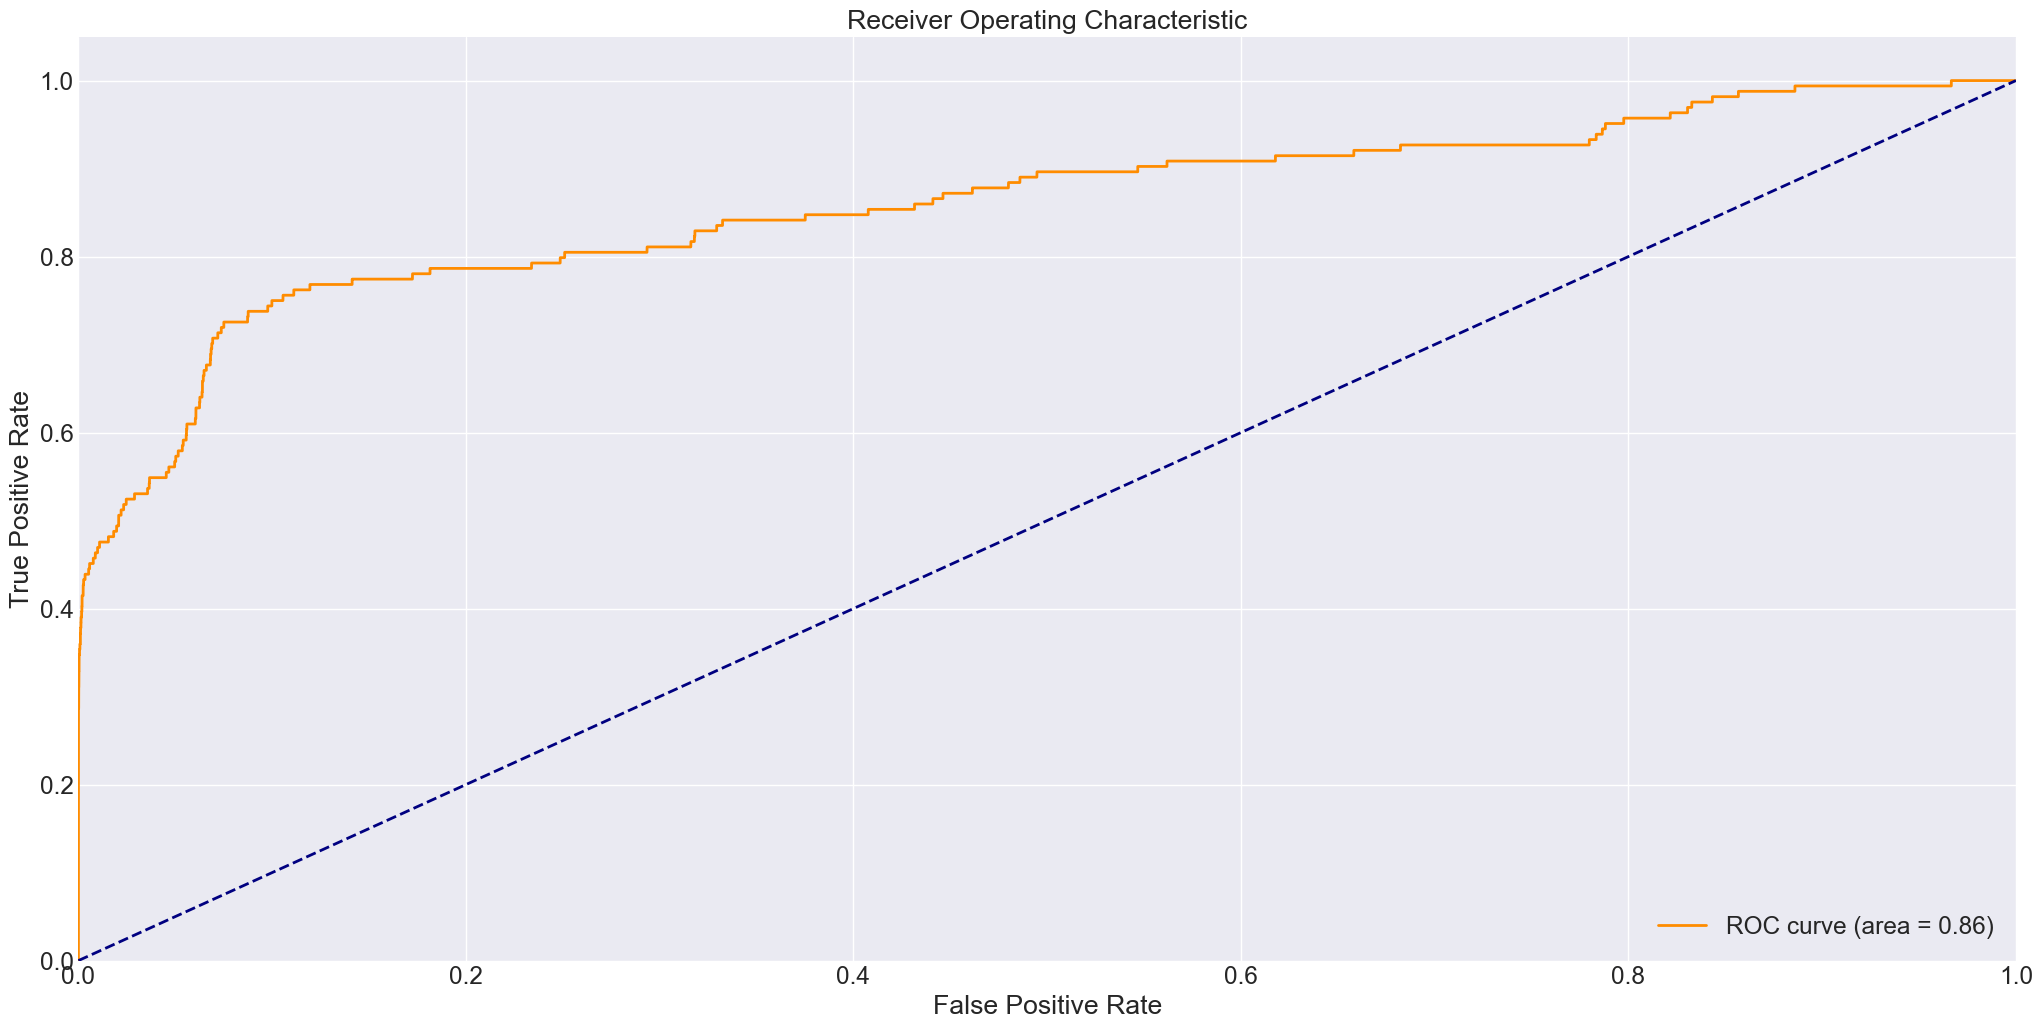

In [57]:
from sklearn.metrics import roc_curve, auc

y_prob = autoencoder.predict(X_test_cs)

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 7.1 Baseline

## 7.2 Logistic Regression

In [58]:
lg = LogisticRegression()
lg.fit(X_train_cs, y_train)

y_pred_log_reg = lg.predict(X_test_cs)

### 7.2.1 Classification Report

In [59]:
print(classification_report(y_test, y_pred_log_reg))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127089
           1       1.00      0.02      0.05       164

    accuracy                           1.00    127253
   macro avg       1.00      0.51      0.52    127253
weighted avg       1.00      1.00      1.00    127253



### 7.2.2 Cross Validation

In [60]:
log_reg_cv = ml_cv_results('LogisticRegression', LogisticRegression(),
                       X_temp_cs, y_temp)
log_reg_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
LogisticRegression,0.546 +/- 0.028,1.0 +/- 0.0,0.093 +/- 0.057,0.165 +/- 0.095,0.165 +/- 0.095


## 7.3 K Nearest Neighbors

In [61]:
knn = KNeighborsClassifier()
knn.fit(X_train_cs, y_train)

y_pred_knn = knn.predict(X_test_cs)

### 7.3.1 Classification Report

In [62]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127089
           1       0.95      0.23      0.36       164

    accuracy                           1.00    127253
   macro avg       0.97      0.61      0.68    127253
weighted avg       1.00      1.00      1.00    127253



### 7.3.2 Cross Validation

In [63]:
knn_cv = ml_cv_results('K Nearest Neighbors', KNeighborsClassifier(),
                       X_temp_cs, y_temp)
knn_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.703 +/- 0.019,0.945 +/- 0.02,0.407 +/- 0.037,0.567 +/- 0.034,0.567 +/- 0.034


## 7.4 Support Vector Machine

In [64]:
svm = SVC()
svm.fit(X_train_cs, y_train)

y_pred_svm = svm.predict(X_test_cs)

### 7.4.1 Classification Report

In [65]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127089
           1       0.00      0.00      0.00       164

    accuracy                           1.00    127253
   macro avg       0.50      0.50      0.50    127253
weighted avg       1.00      1.00      1.00    127253



### 7.4.2 Cross Validation

In [66]:
svm_cv = ml_cv_results('SVM', SVC(),
                       X_temp_cs, y_temp)
svm_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.595 +/- 0.022,1.0 +/- 0.0,0.19 +/- 0.044,0.317 +/- 0.063,0.317 +/- 0.063


## 7.5 Random Forest

In [67]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_cs, y_train)

y_pred_rf = rf.predict(X_test_cs)

### 7.5.1 Classification Report

In [68]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127089
           1       0.98      0.75      0.85       164

    accuracy                           1.00    127253
   macro avg       0.99      0.87      0.92    127253
weighted avg       1.00      1.00      1.00    127253



### 7.5.2 Cross Validation

In [69]:
rf_cv = ml_cv_results('Random Forest', RandomForestClassifier(),
                       X_temp_cs, y_temp)
rf_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.862 +/- 0.012,0.966 +/- 0.022,0.725 +/- 0.025,0.828 +/- 0.023,0.828 +/- 0.023


## 7.6 XGBoost

In [70]:
xgb = XGBClassifier()
xgb.fit(X_train_cs, y_train)

y_pred_xgb = xgb.predict(X_test_cs)

### 7.6.1 Classification Report

In [71]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127089
           1       0.96      0.83      0.89       164

    accuracy                           1.00    127253
   macro avg       0.98      0.91      0.95    127253
weighted avg       1.00      1.00      1.00    127253



### 7.6.2 Cross Validation

In [72]:
xgb_cv = ml_cv_results('XGBoost', XGBClassifier(),
                       X_temp_cs, y_temp)
xgb_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.887 +/- 0.017,0.952 +/- 0.02,0.773 +/- 0.034,0.853 +/- 0.02,0.853 +/- 0.02


## 7.7 LightGBM

In [73]:
lightgbm = LGBMClassifier()
lightgbm.fit(X_train_cs, y_train)

y_pred_lgbm = lightgbm.predict(X_test_cs)

[LightGBM] [Info] Number of positive: 526, number of negative: 406681
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 407207, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001292 -> initscore=-6.650483
[LightGBM] [Info] Start training from score -6.650483


### 7.7.1 Classification Report

In [74]:
print(classification_report(y_test, y_pred_lgbm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127089
           1       0.42      0.57      0.48       164

    accuracy                           1.00    127253
   macro avg       0.71      0.79      0.74    127253
weighted avg       1.00      1.00      1.00    127253



### 7.7.2 Cross Validation

In [75]:
lightgbm_cv = ml_cv_results('LightGBM', LGBMClassifier(),
                            X_temp_cs, y_temp)
lightgbm_cv

Fold K=1
[LightGBM] [Info] Number of positive: 526, number of negative: 406681
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 407207, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001292 -> initscore=-6.650483
[LightGBM] [Info] Start training from score -6.650483
Fold K=2
[LightGBM] [Info] Number of positive: 526, number of negative: 406681
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 407207, number of used features: 7
[L

,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGBM,0.621 +/- 0.093,0.178 +/- 0.148,0.246 +/- 0.183,0.203 +/- 0.168,0.201 +/- 0.168


## 7.8 Comparing Model's Performance

**Logistic Regression ROC AUC**

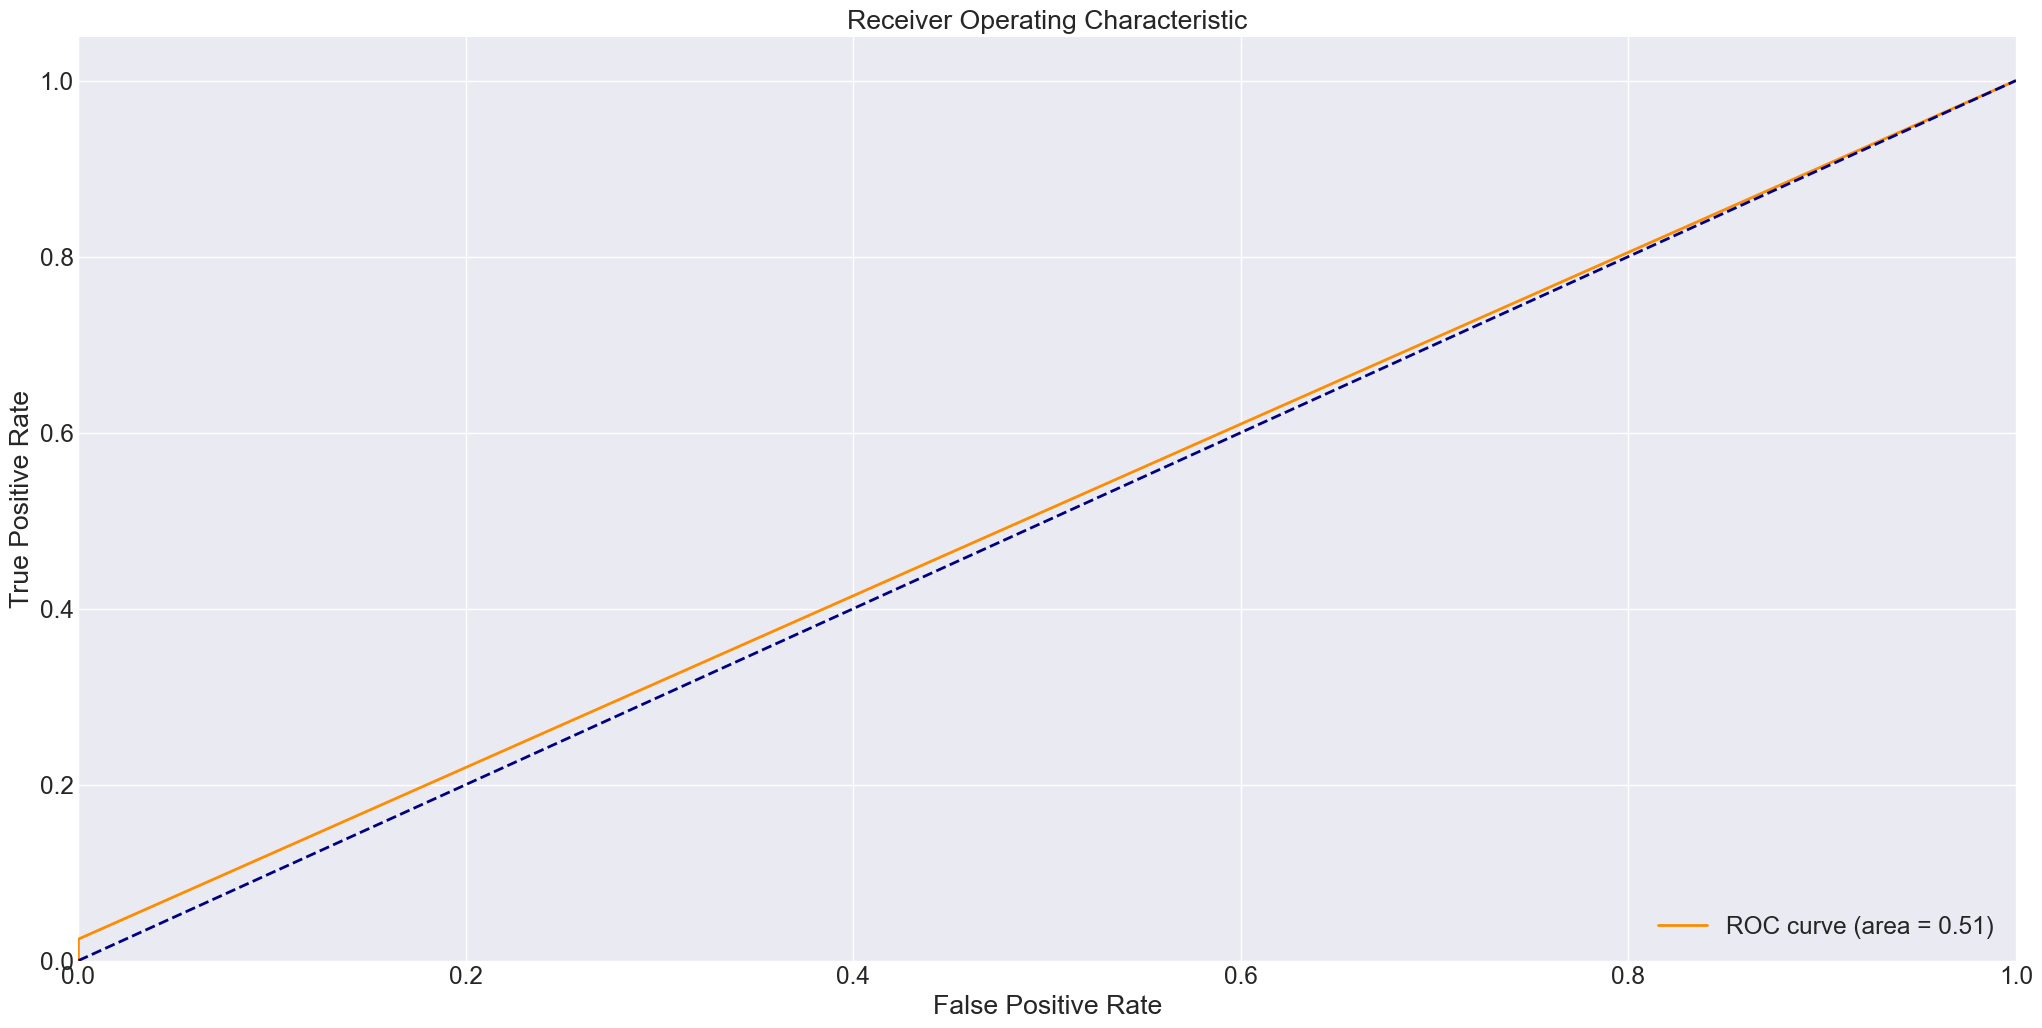

In [76]:
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_pred_log_reg)
roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)

plt.figure()
plt.plot(fpr_log_reg, tpr_log_reg, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_log_reg)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**KNN ROC AUC**

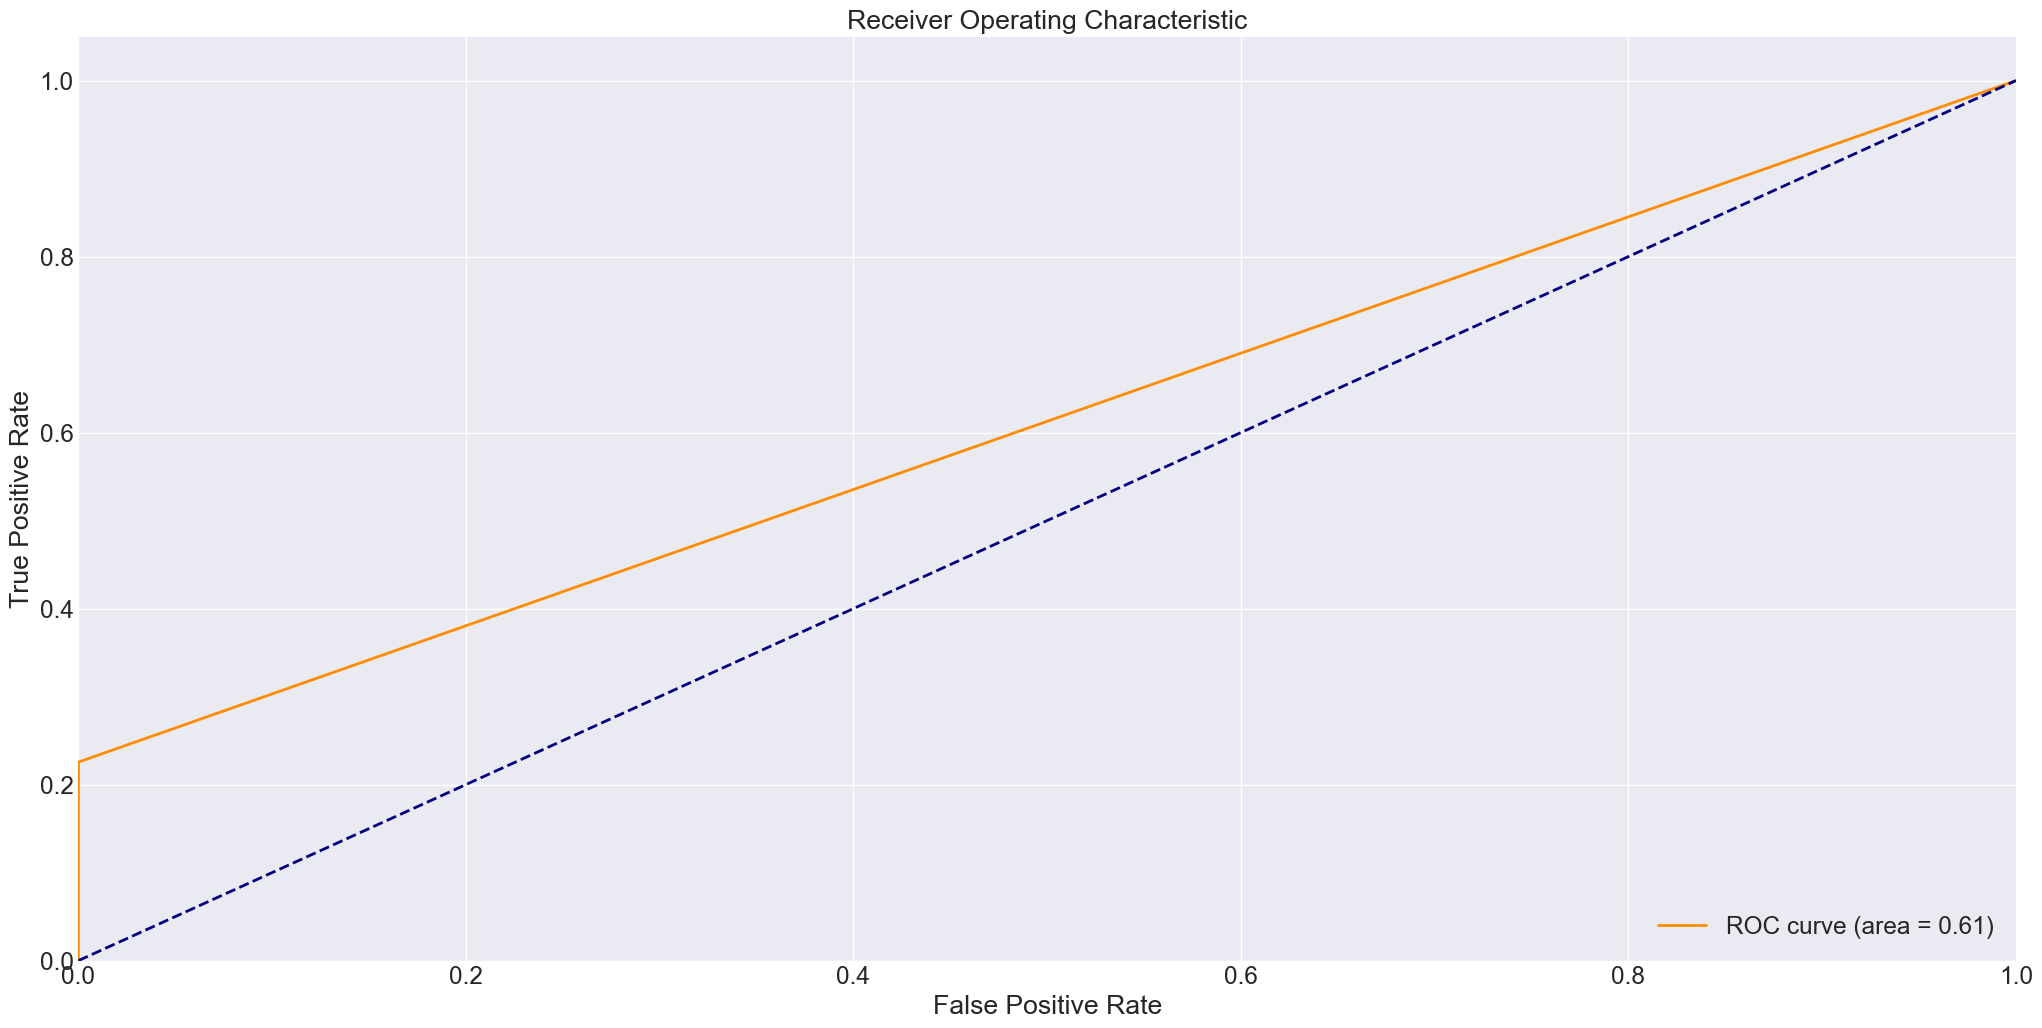

In [77]:
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure()
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**SVM ROC AUC**

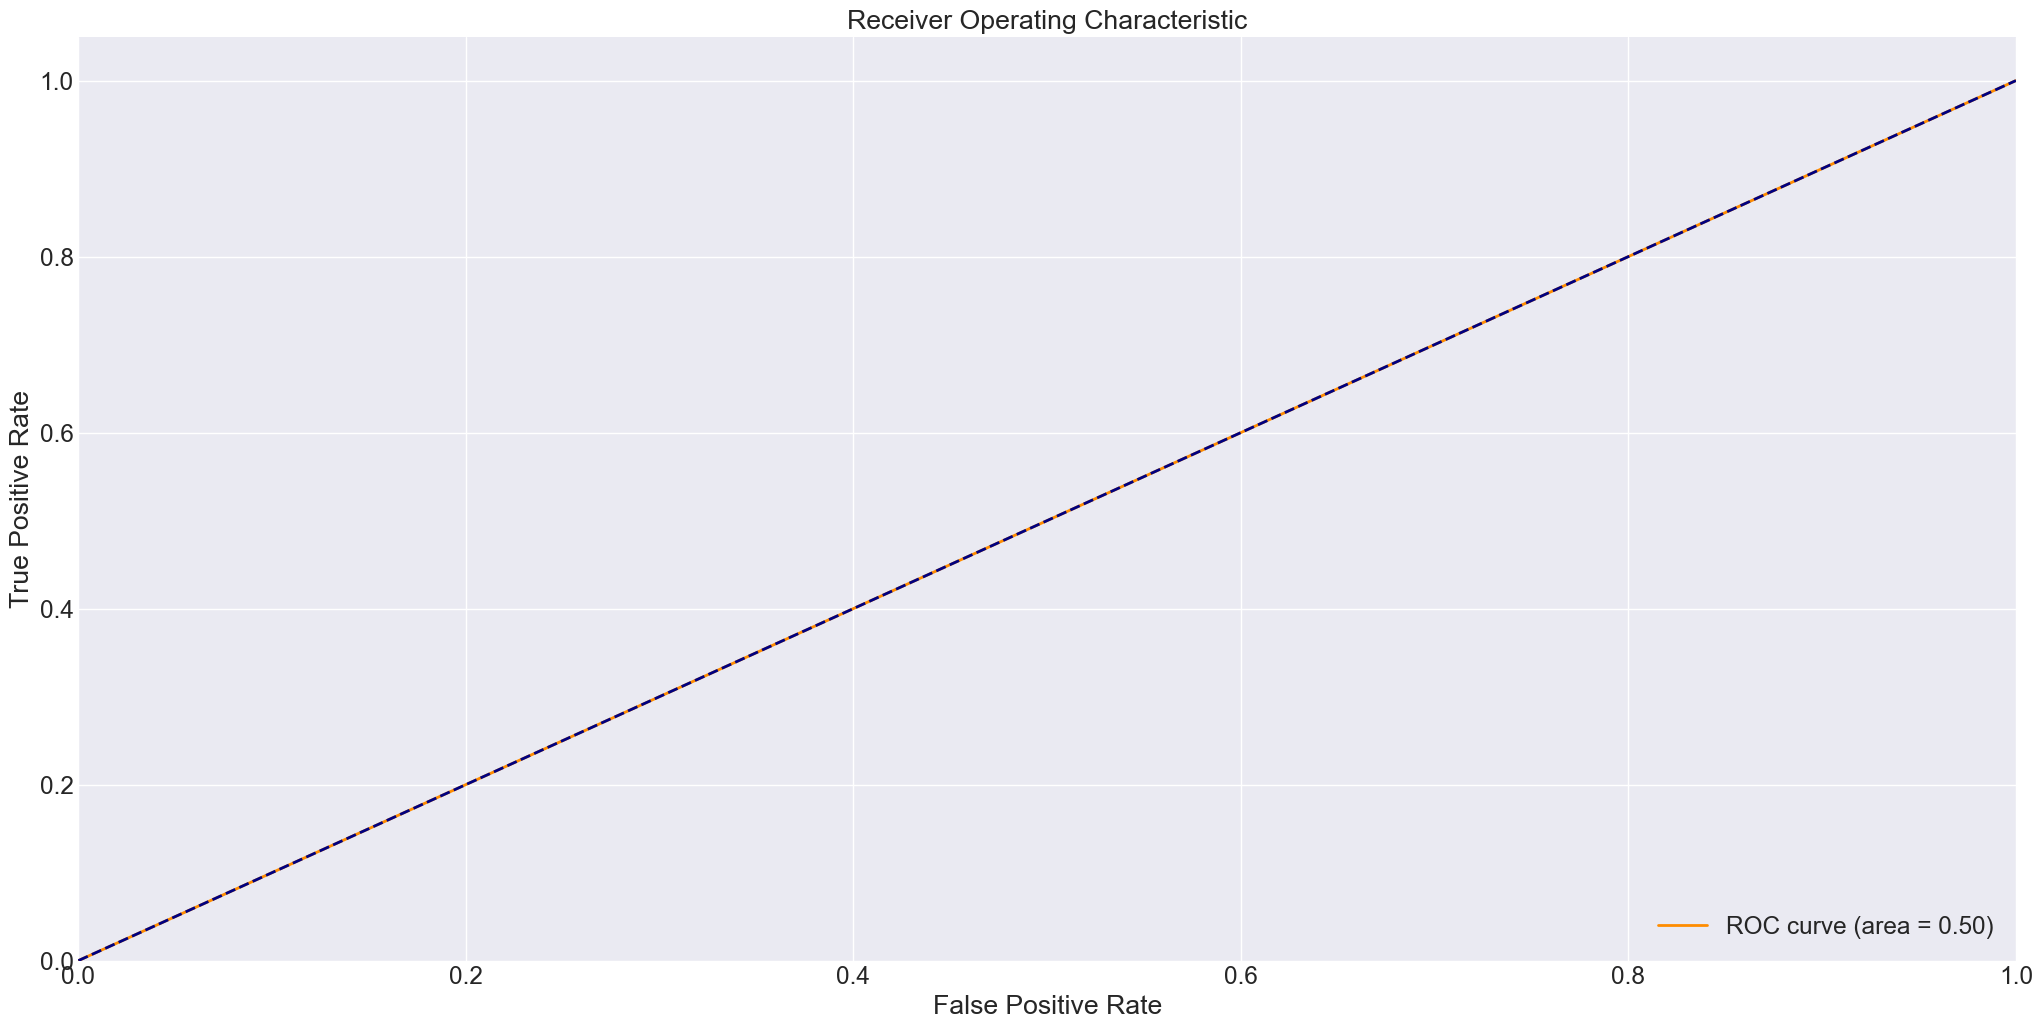

In [78]:
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**Random Forest Classifier ROC AUC**

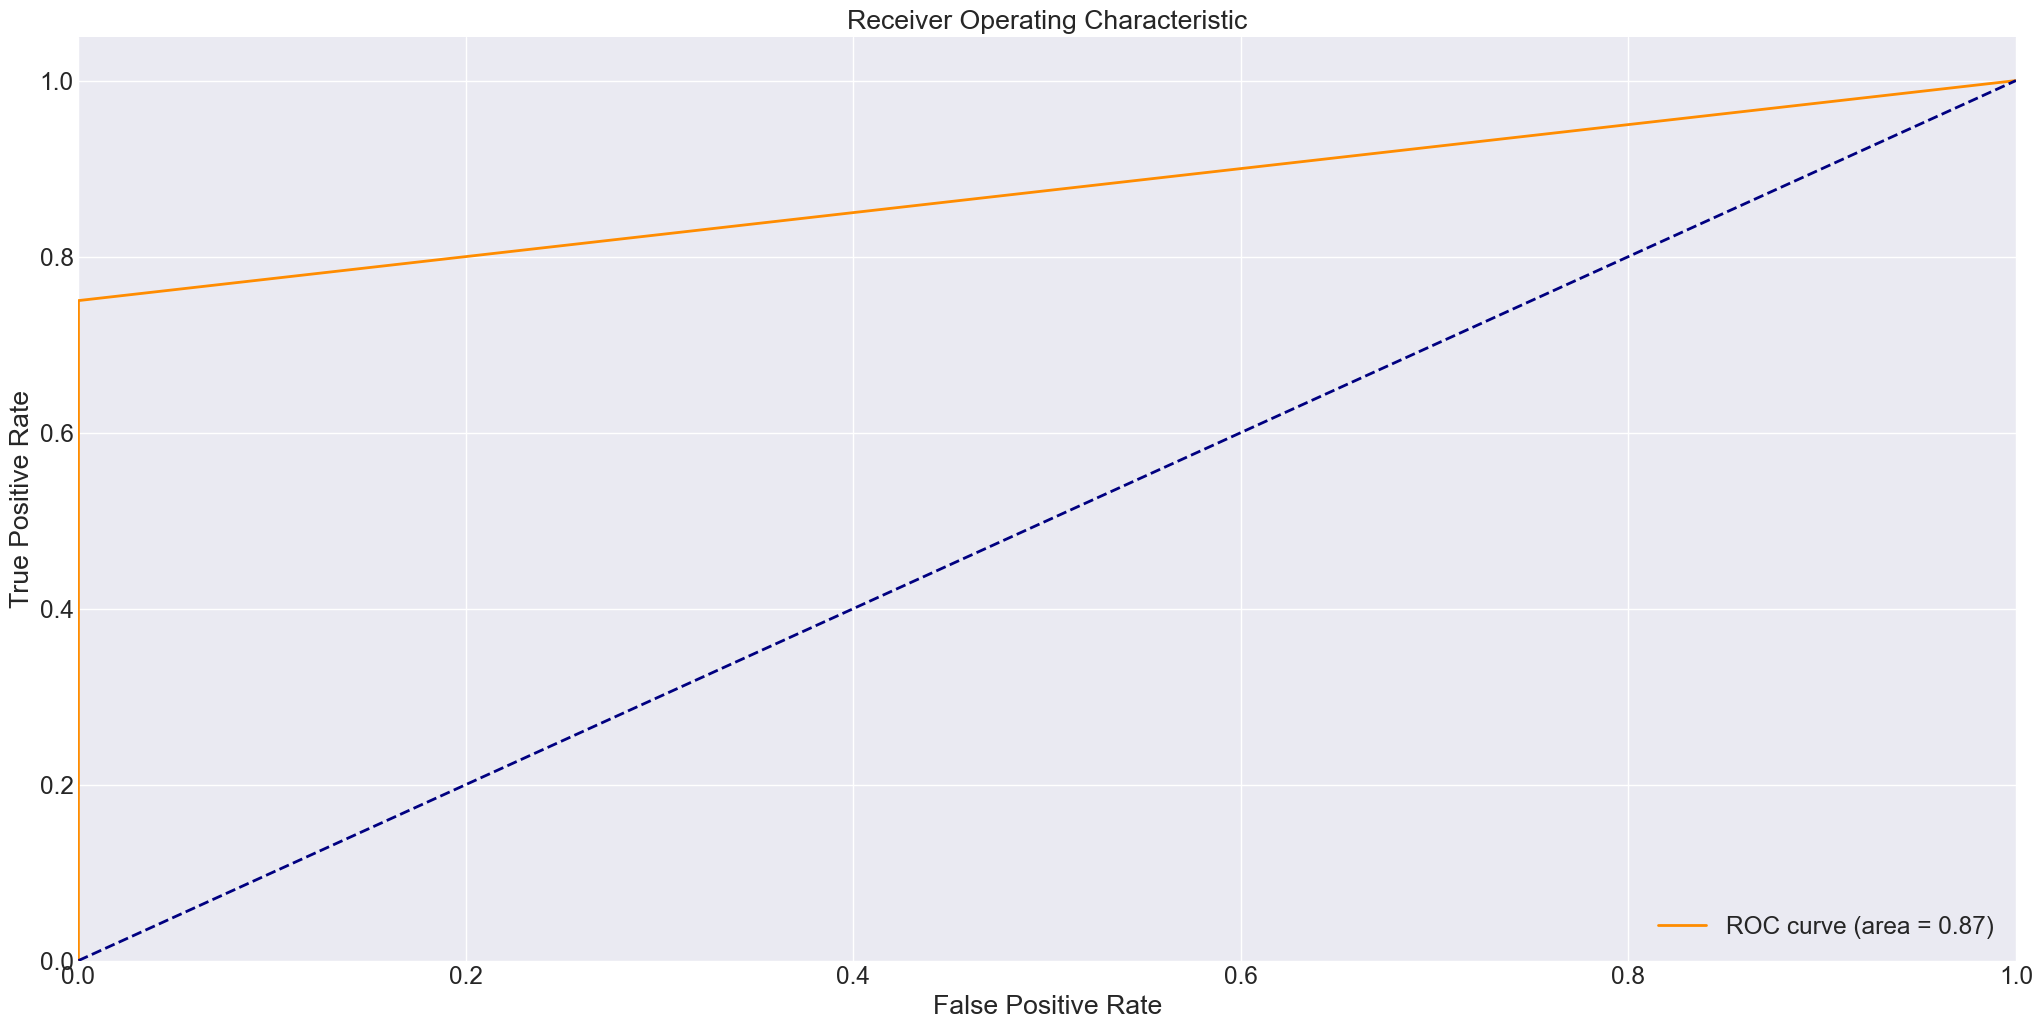

In [79]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**XGBoost ROC AUC**

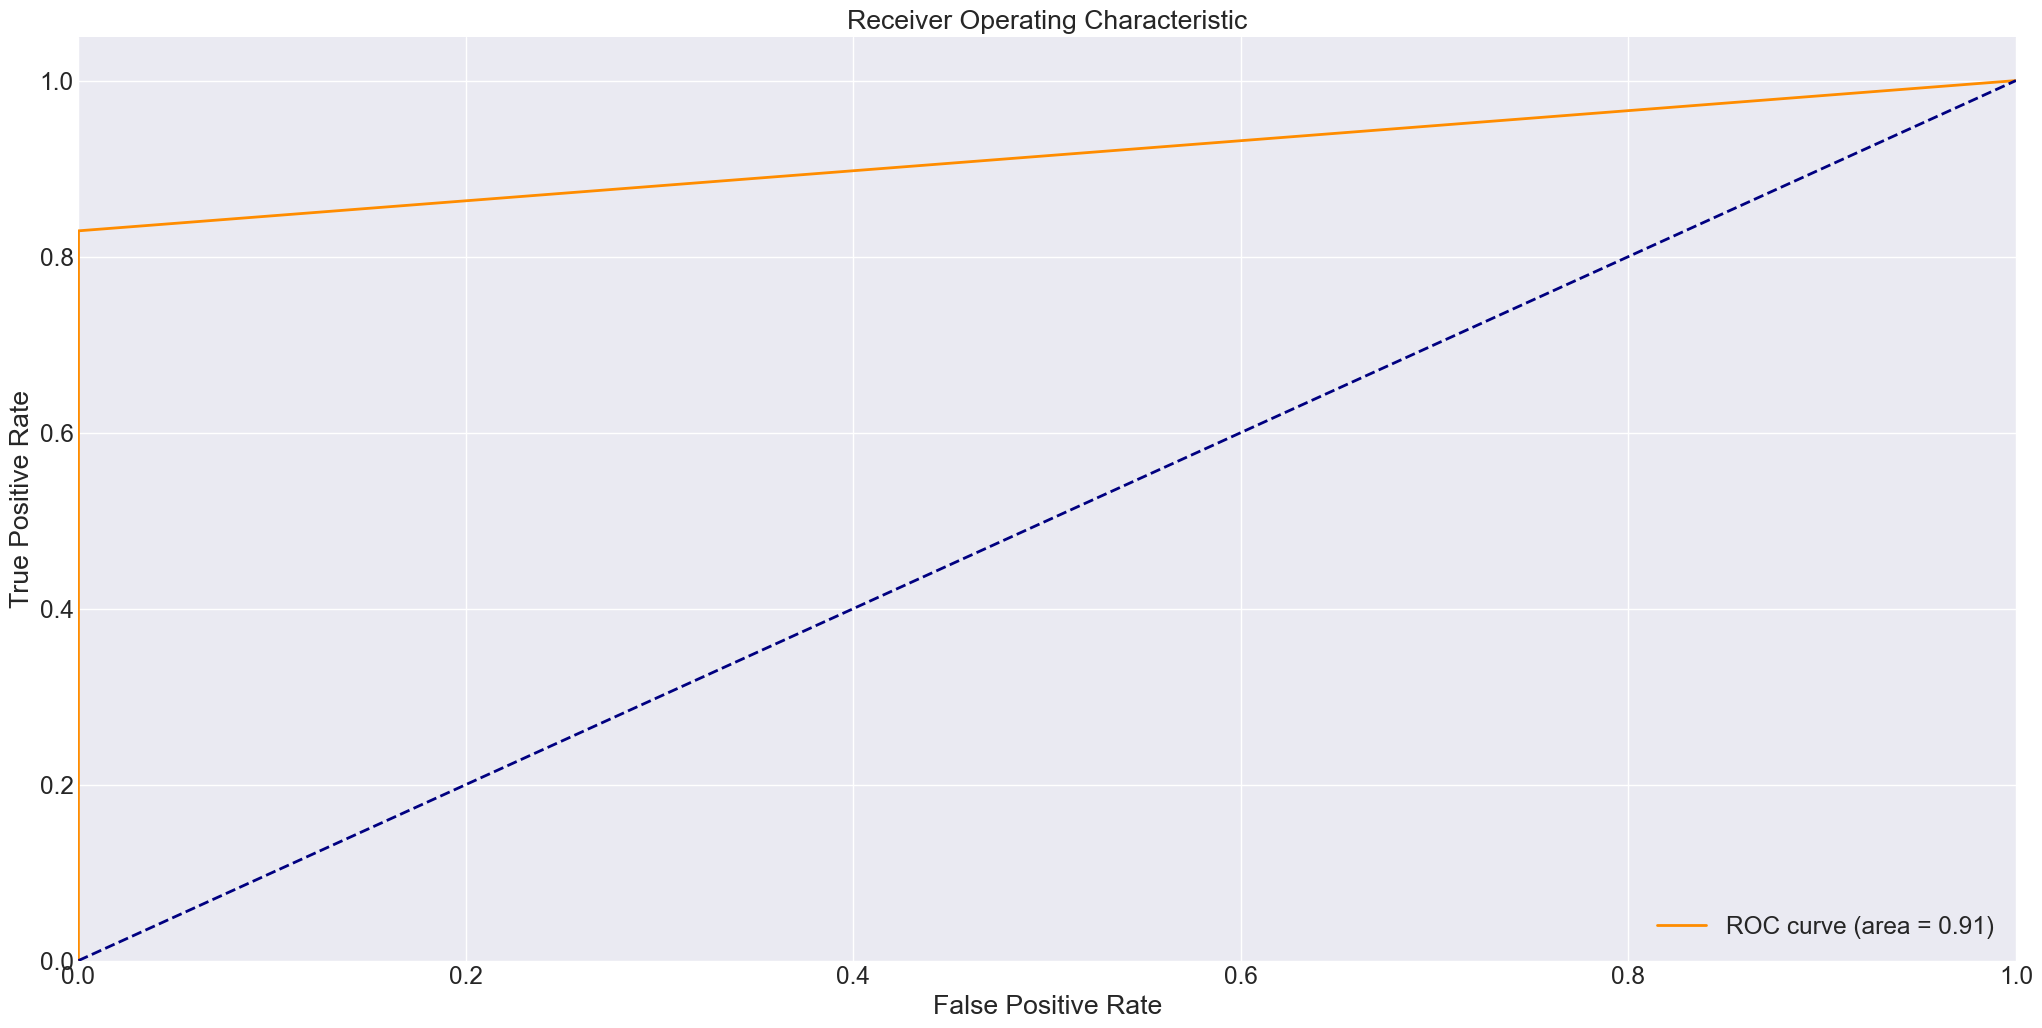

In [80]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

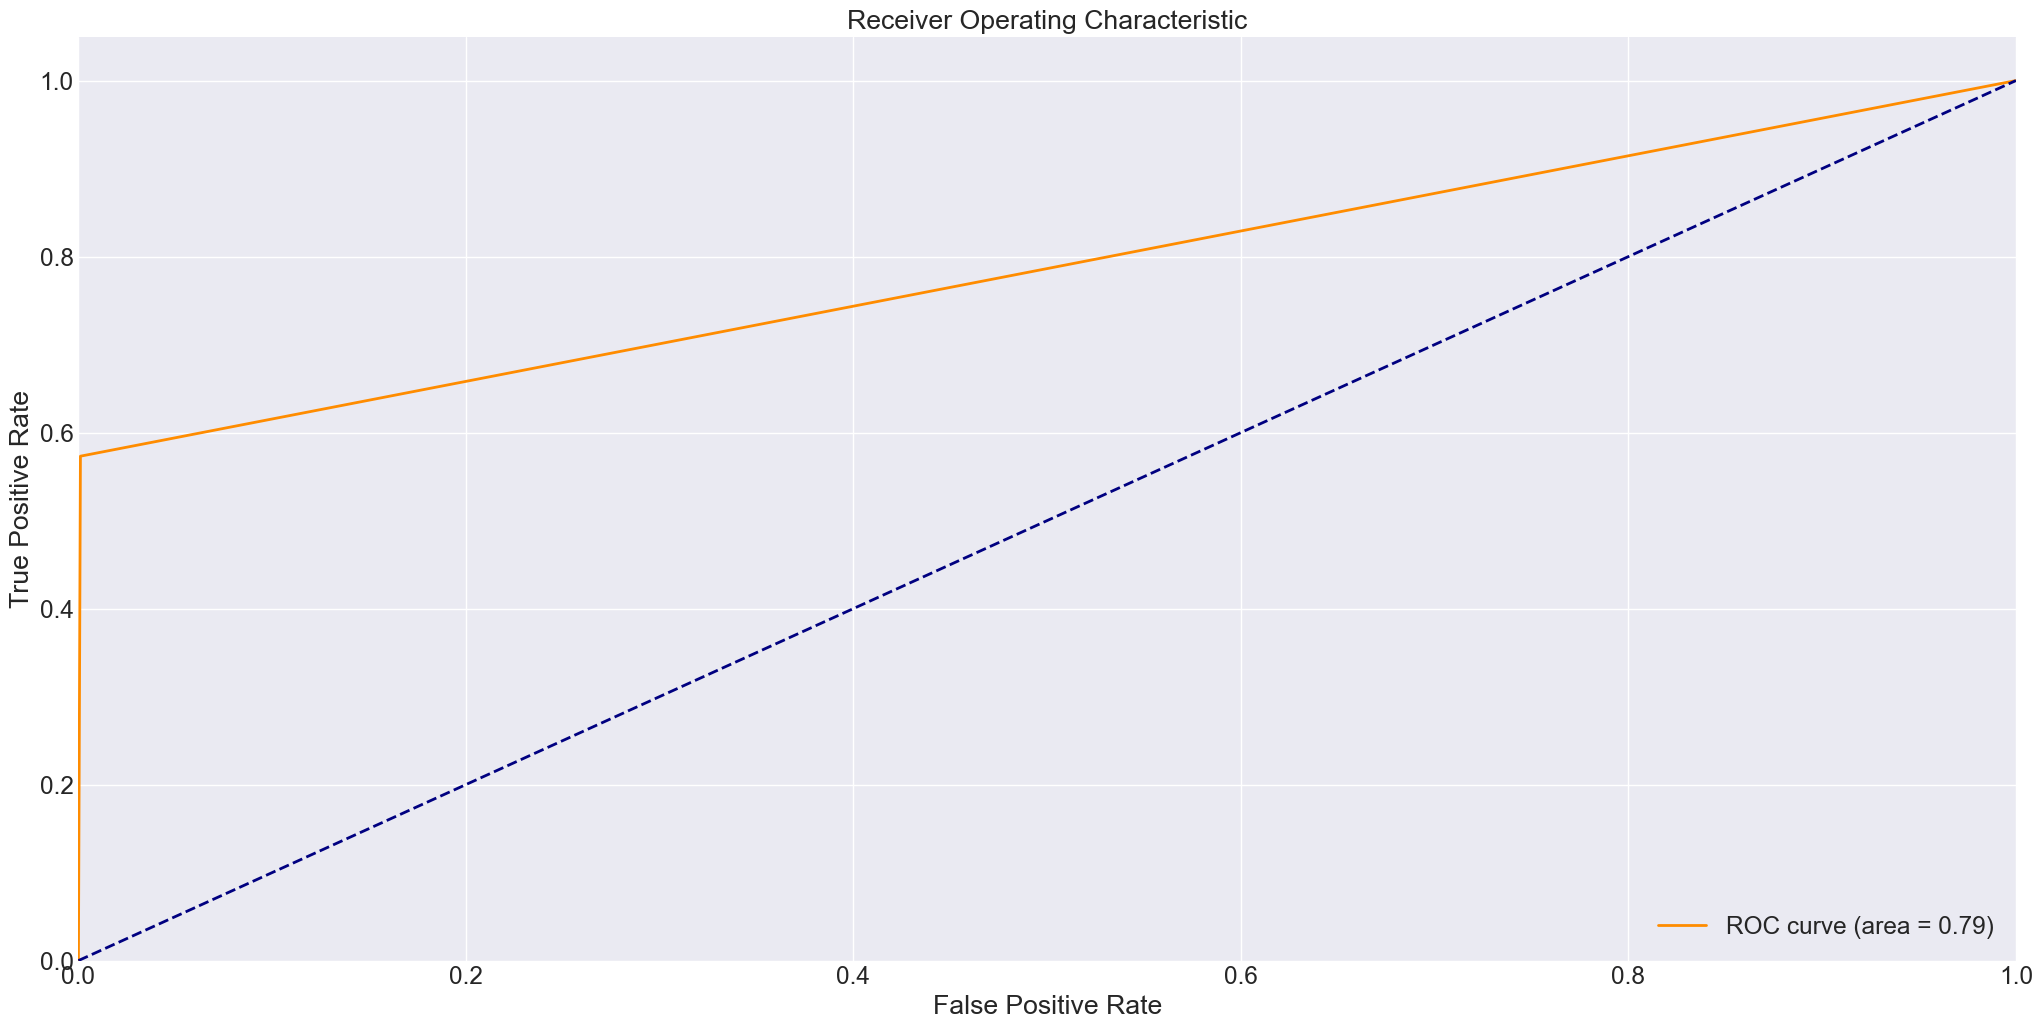

In [81]:
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred_lgbm)
roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

plt.figure()
plt.plot(fpr_lgbm, tpr_lgbm, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_lgbm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 8.0 Hyperparameter Fine Tuning

In [82]:
f1 = make_scorer(f1_score)

In [83]:
params = {
    'booster': ['gbtree', 'gblinear', 'dart'],
    'eta': [0.3, 0.1, 0.01],
    'scale_pos_weight': [1, 774, 508, 99]
}

In [84]:
gs = GridSearchCV(XGBClassifier(),
                  param_grid=params,
                  scoring=f1,
                  cv=StratifiedKFold(n_splits=5))

gs.fit(X_train_cs, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'booster': ['gbtree', 'gblinear', 'dart'],
                         'eta': [0.3, 0.1, 0.01],
                         'scale_pos_weight': [1, 774, 508, 99]},
             scoring=make_scorer(f1_score, response_method='predict'))

In [85]:
best_params = gs.best_params_
best_params

{'booster': 'gbtree', 'eta': 0.3, 'scale_pos_weight': 1}

In [86]:
best_params = {'booster': 'gbtree', 'eta': 0.3, 'scale_pos_weight': 1}

In [87]:
gs.best_score_

0.8356270556486265

## 8.1 Results

In [88]:
xgb_gs = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

In [89]:
xgb_gs.fit(X_train_cs, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [90]:
y_pred_xgb_final = xgb_gs.predict(X_test_cs)

### 8.1.2 Cross Validation

In [94]:
xgb_gs_cv = ml_cv_results('XGBoost GS', xgb_gs, X_temp_cs, y_temp)
xgb_gs_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost GS,0.879 +/- 0.019,0.943 +/- 0.027,0.758 +/- 0.038,0.84 +/- 0.034,0.84 +/- 0.034


# 9.0 API
Saving our best model to use it in the app:

In [104]:
import joblib
import os

path = os.path.expanduser('~/xgb_gs.joblib')

joblib.dump(xgb_gs, path)

['/Users/shklyarmike/xgb_gs.joblib']

Printing columns and test data that will be used in application:

In [105]:
print(X_train_cs.columns.tolist())
print(X_train_cs.head())

['step', 'oldbalance_org', 'newbalance_orig', 'newbalance_dest', 'diff_new_old_balance', 'diff_new_old_destiny', 'type_TRANSFER']
        step  oldbalance_org  newbalance_orig  newbalance_dest  diff_new_old_balance  diff_new_old_destiny  type_TRANSFER
418833   304        0.000013         0.000707         0.001815              0.881133              0.069490              0
535343   448        0.000000         0.000000         0.004738              0.878805              0.073839              0
419647   129        0.000000         0.000000         0.009856              0.878805              0.082316              1
358991    14        0.000000         0.000000         0.004747              0.878805              0.079537              0
186087   331        0.000000         0.000000         0.034297              0.878805              0.071922              1


Testing the model on a specific example:

In [106]:
test_data = pd.DataFrame([{
    "step": 304,
    "oldbalance_org": 0.000013,
    "newbalance_orig": 0.000070,
    "newbalance_dest": 0.001815,
    "diff_new_old_balance": 0.881133,
    "diff_new_old_destiny": 0.069490,
    "type_TRANSFER": 0
}], index=[0])

# Prediction
prediction = xgb_gs.predict(test_data)
print(prediction)

[0]


# 10.0 Conclusions

The best model with high score & performance is XGBoost Classifier